In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import learning_curve
# set up notebook to show all outputs in a cell, not only last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.pandas import PandasDataset
from sklearn.metrics import mean_squared_error
import numpy as np
import os
from datasets import load_dataset  # Import the load_dataset function

In [3]:
df = pd.read_csv("cleaned_data (5).csv")
df.fillna({"Native Hawaiian and Other Pacific Islander": 0,"White":0}, inplace=True)
df.head()

Year      White  Black or African American  \
0  1990  2987764.0                  1024198.0   
1  1991  3018779.0                  1040280.0   
2  1992  3051680.0                  1060627.0   
3  1993  3088449.0                  1081479.0   
4  1994  3114389.0                  1099593.0   

   American Indian and Alaska Native    Asian  \
0                            16224.0  21869.0   
1                            17015.0  23082.0   
2                            17357.0  24350.0   
3                            18002.0  26272.0   
4                            18566.0  27681.0   

   Native Hawaiian and Other Pacific Islander     White   
0                                         0.0  2987764.0  
1                                         0.0  3018779.0  
2                                         0.0  3051680.0  
3                                         0.0  3088449.0  
4                                         0.0  3114389.0

In [4]:
white_vals = df["White"].values
black_vals = df["Black or African American"].values
AIAN_vals = df["American Indian and Alaska Native"].values
asian_vals = df["Asian"].values
PI_values = df["Native Hawaiian and Other Pacific Islander"].values

In [5]:
class StateDataset:
    """
    Handles data loading and preprocessing for a single state.
    """
    def __init__(self, state_name):
        self.state_name = state_name
        self.data = None
        self.races = [
            "White",
            "Asian",
            "Native Hawaiian and Other Pacific Islander",
            "American Indian and Alaska Native",
            "Black or African American",
        ]

    def load_and_prepare_data(self, dataset_path):
        """
        Load dataset from HuggingFace and preprocess it.
        """
        # Load dataset and convert to Pandas DataFrame
        df = load_dataset(dataset_path, split='train').to_pandas()

        # Ensure 'Date' is datetime and melt to long format
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
        df = df.melt(id_vars='Date', var_name='type_id', value_name='population')

        # Filter only the specified races
        df = df[df['type_id'].isin(self.races)]

        # Set 'Date' as index and ensure float32 for numeric data
        df.set_index('Date', inplace=True)
        df['population'] = pd.to_numeric(df['population'], errors='coerce').astype('float32')

        self.data = df
    def get_grouped_data(self):
        """
        Group data by 'type_id' (ethnic group).
        """
        if self.data is None:
            raise ValueError("Data has not been loaded. Please call load_and_prepare_data() first.")
        return self.data.groupby("type_id")

In [6]:
class RegressionAnalysis:
    """
    Performs linear regression analysis on datasets from multiple states.
    """
    def __init__(self):
        self.datasets = {}
        self.regressions = {}

    def add_state_data(self, state_name, dataset):
        """
        Add a preprocessed dataset for a state.
        """
        self.datasets[state_name] = dataset
    def plot_results(self):
    
     for state, races_data in self.regressions.items():
        print(f"Plotting results for {state}...")

        # Number of ethnic groups to plot
        num_races = len(races_data)

        # Create subplots
        fig, axs = plt.subplots(num_races, 1, figsize=(10, 5 * num_races))
        fig.suptitle(f"Regression Results for {state}", fontsize=16, y=1.02)

        # Ensure axs is always iterable
        if num_races == 1:
            axs = [axs]

        for ax, (race, result) in zip(axs, races_data.items()):
            model = result["model"]
            X = result["X"]
            y = result["y"]

            # Scatter plot of actual data
            ax.scatter(X, y, label="Actual Data", alpha=0.7)

            # Regression line
            X_sorted = np.sort(X, axis=0)
            y_pred = model.predict(X_sorted)
            ax.plot(X_sorted, y_pred, color="red", label="Regression Line")

            # Customize plot
            ax.set_title(f"{state} - {race}")
            ax.set_xlabel("Year")
            ax.set_ylabel("Population (thousands)")
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

    def perform_regression(self):
     for state, dataset in self.datasets.items():
        grouped_data = dataset.get_grouped_data()
        self.regressions[state] = {}

        for race in dataset.races:
            if race not in grouped_data.groups:
                print(f"Skipping {race} for {state}: No data available.")
                continue

            # Extract data for the race
            group_df = grouped_data.get_group(race)
            X = group_df.index.year.values.reshape(-1, 1)
            y = group_df['population'].values.reshape(-1, 1)

            # Handle missing values in y
            valid_indices = ~pd.isna(y).flatten()
            X = X[valid_indices]
            y = y[valid_indices]

            # Skip if no valid data points
            if len(y) == 0:
                print(f"Skipping regression for {state}, {race} due to no valid data.")
                continue

            # Split into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

            # Fit linear regression
            regr = LinearRegression()
            regr.fit(X_train, y_train)

            # Calculate metrics
            mse = mean_squared_error(y_test, regr.predict(X_test))
            r_squared = regr.score(X_test, y_test)

            # Store results
            self.regressions[state][race] = {
                "model": regr,
                "mse": mse,
                "r_squared": r_squared,
                "X": X,
                "y": y,
            }

    def get_results(self):
        """
        Return regression results for all states and ethnic groups.
        """
        return self.regressions
    def plot_results(self):
        """
        Plot regression results for each state and race.
        """
        for state, races_data in self.regressions.items():
            print(f"Plotting results for {state}...")
            fig, axs = plt.subplots(len(races_data), 1, figsize=(10, 6 * len(races_data)))

            if len(races_data) == 1:  # Single subplot case
                axs = [axs]

            for ax, (race, result) in zip(axs, races_data.items()):
                model = result["model"]
                X = result["X"]
                y = result["y"]

                # Scatter plot of actual data
                ax.scatter(X, y, label="Actual Data", alpha=0.7)

                # Regression line
                X_sorted = np.sort(X, axis=0)
                y_pred = model.predict(X_sorted)
                ax.plot(X_sorted, y_pred, color="red", label="Regression Line")

                # Customize plot
                ax.set_title(f"{state} - {race}")
                ax.set_xlabel("Year")
                ax.set_ylabel("Population (thousands)")
                ax.legend()
                ax.grid(True)

            plt.tight_layout()
            plt.show()

Plotting results for California...


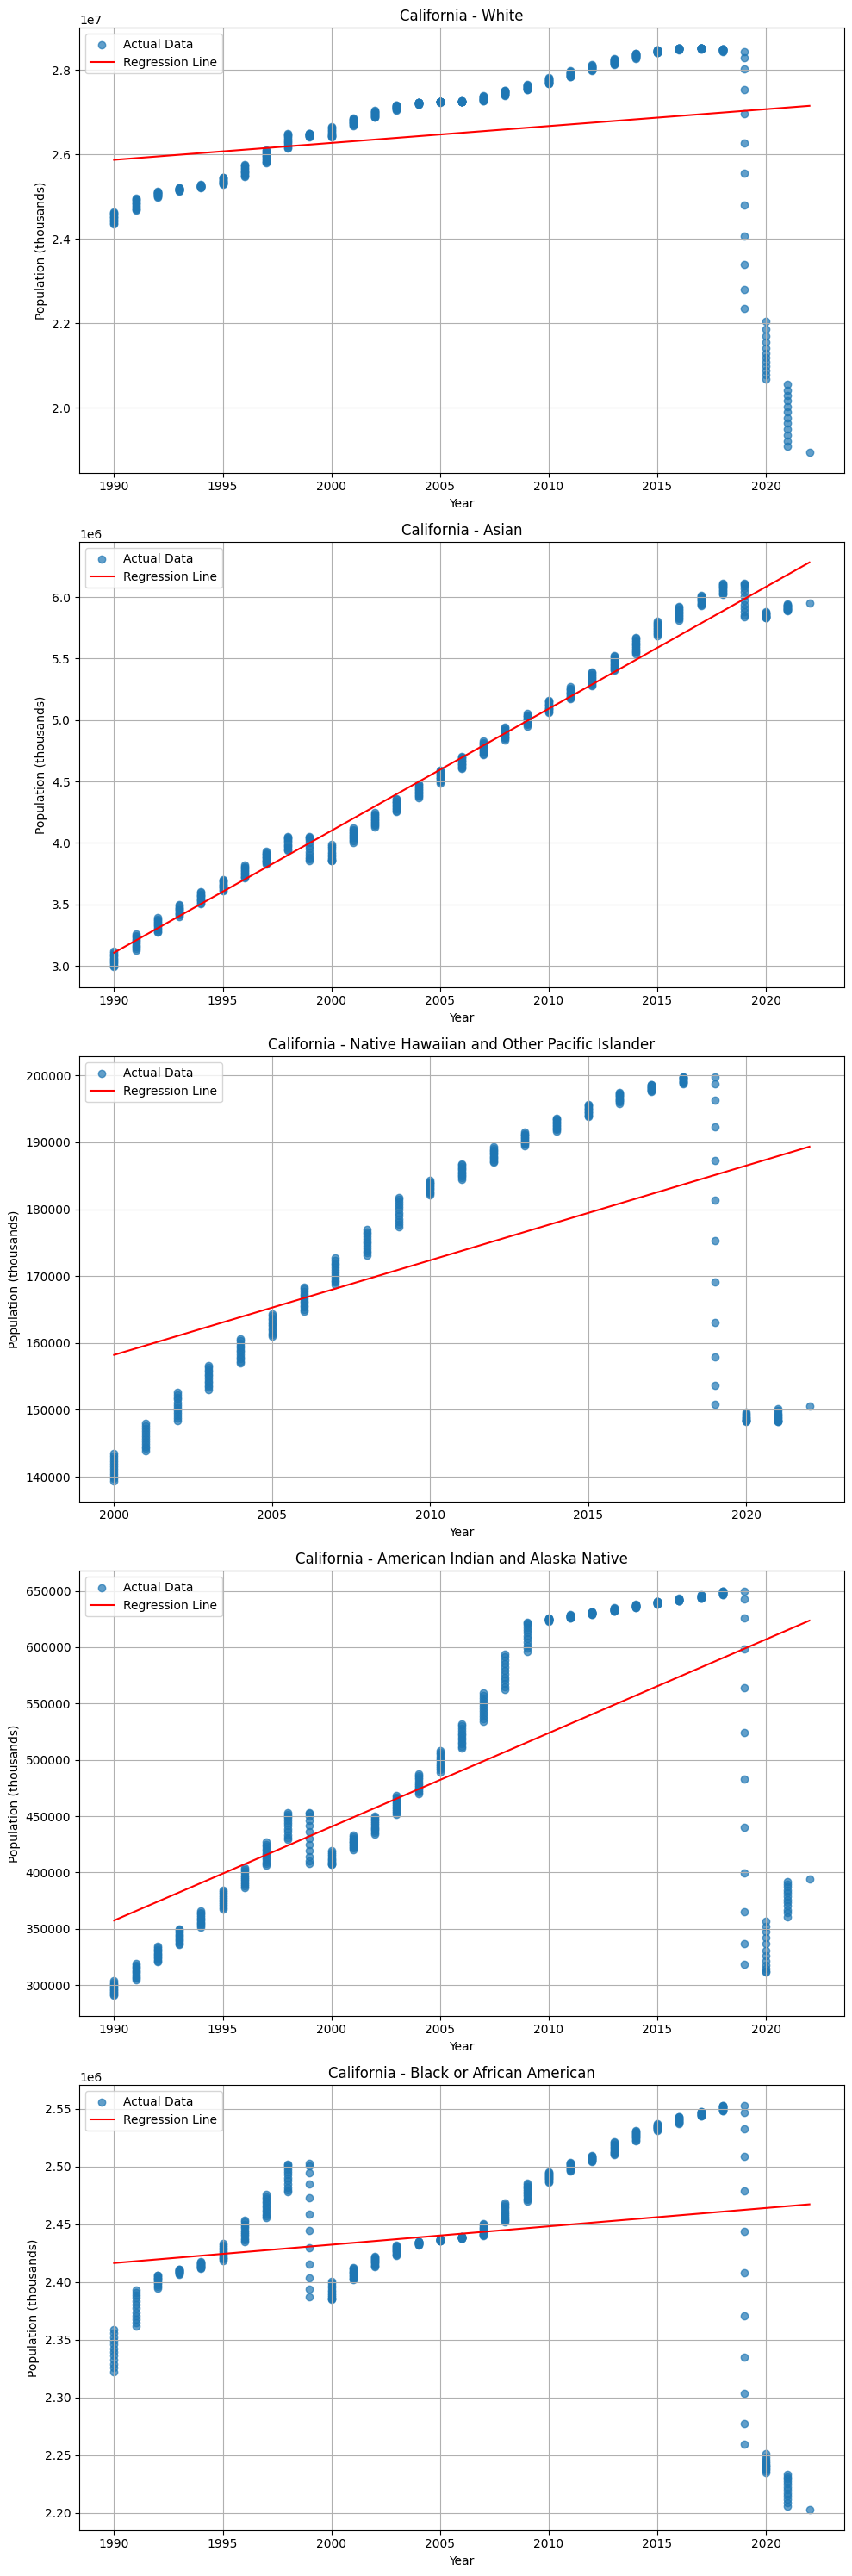

Plotting results for California...


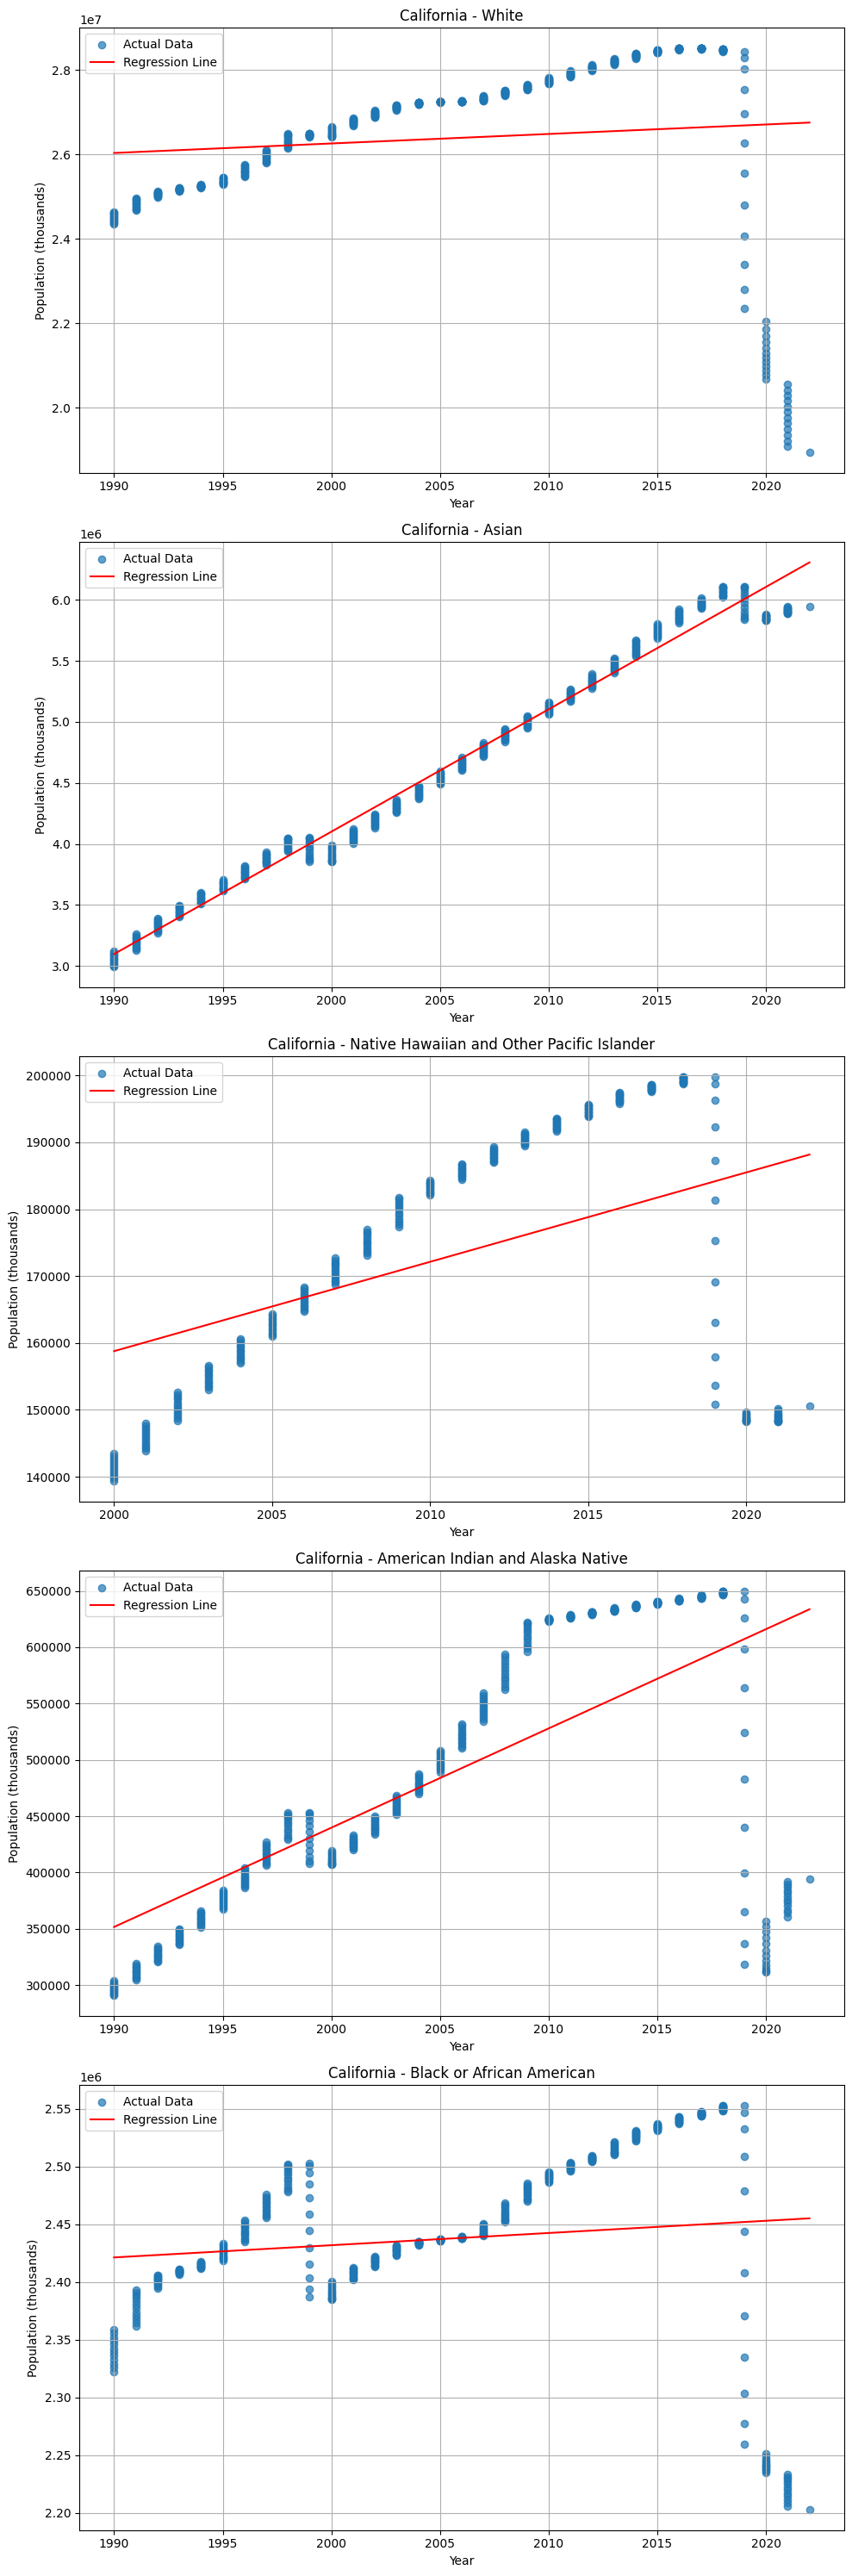

Plotting results for Alabama...


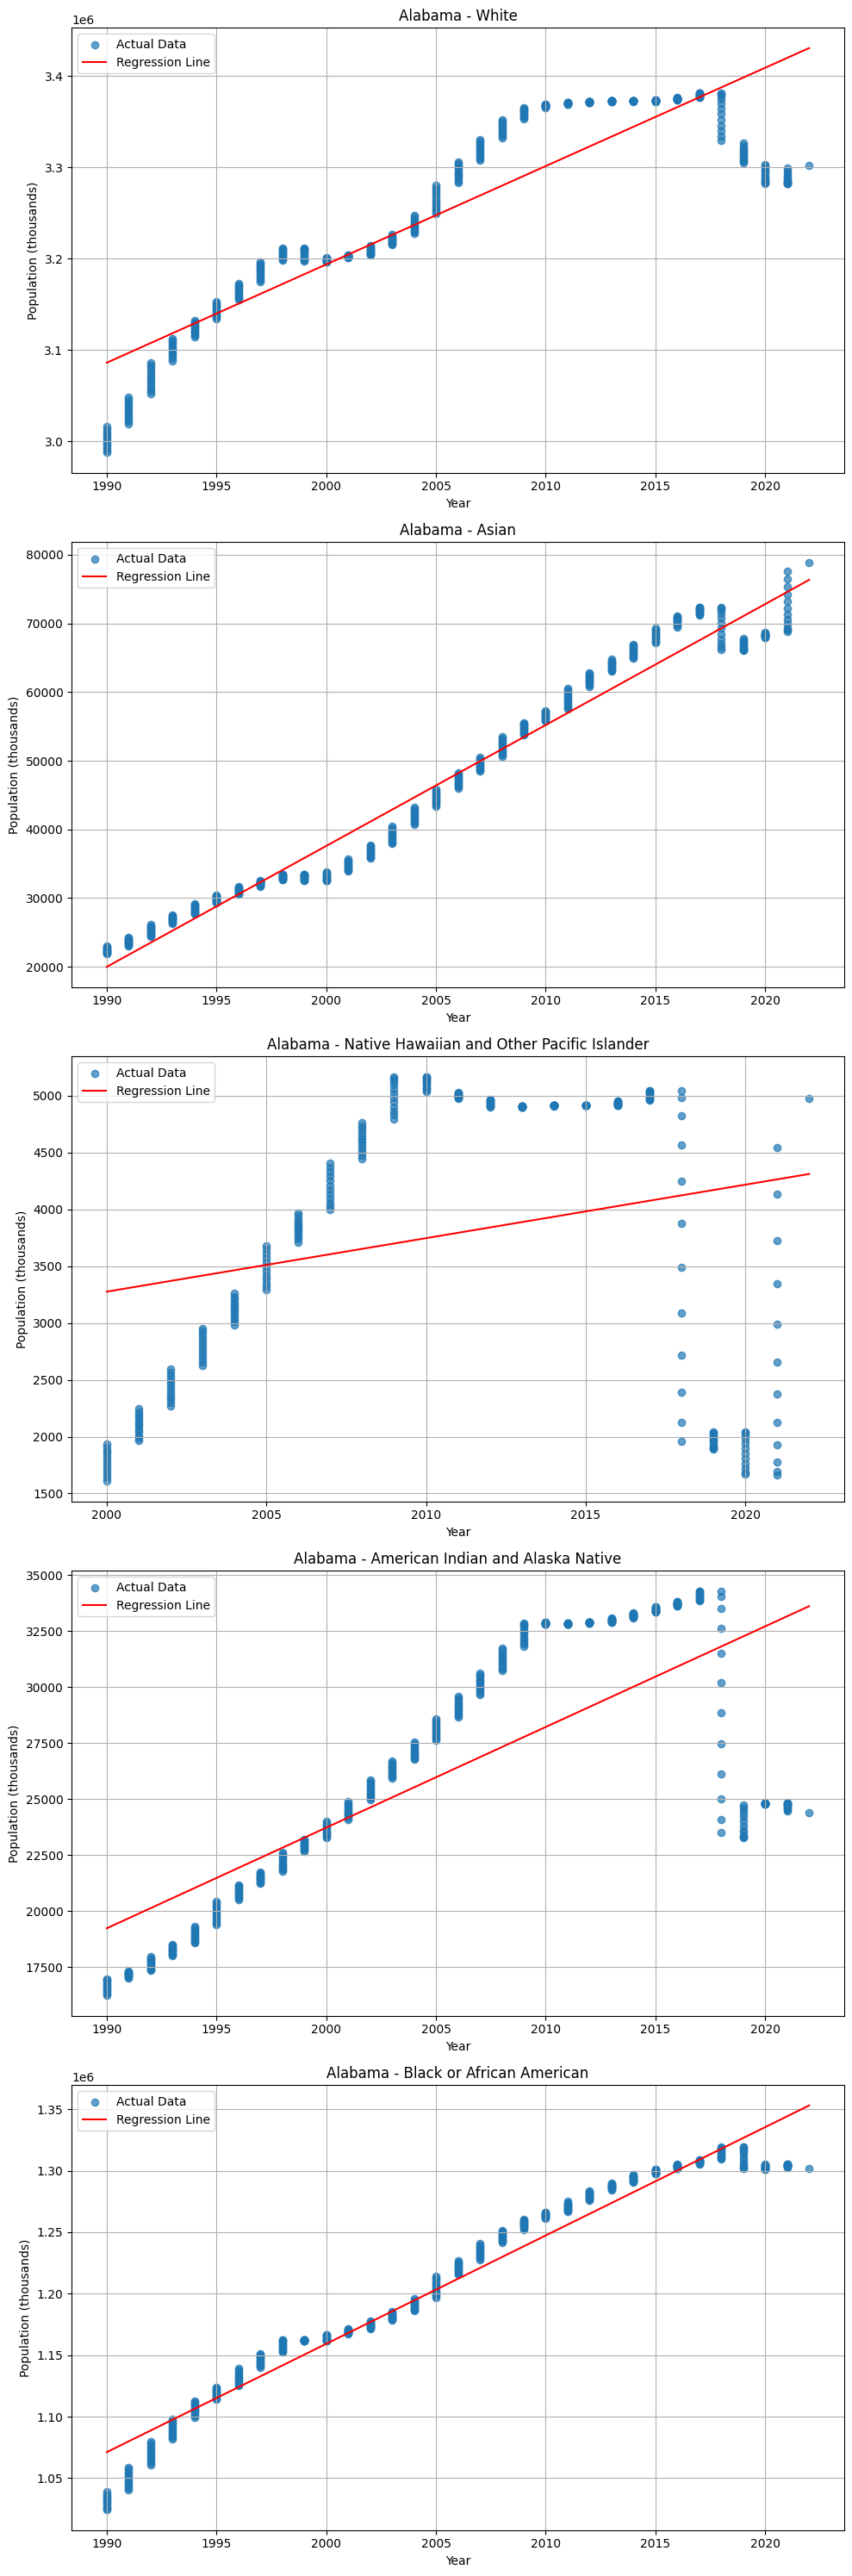

Plotting results for California...


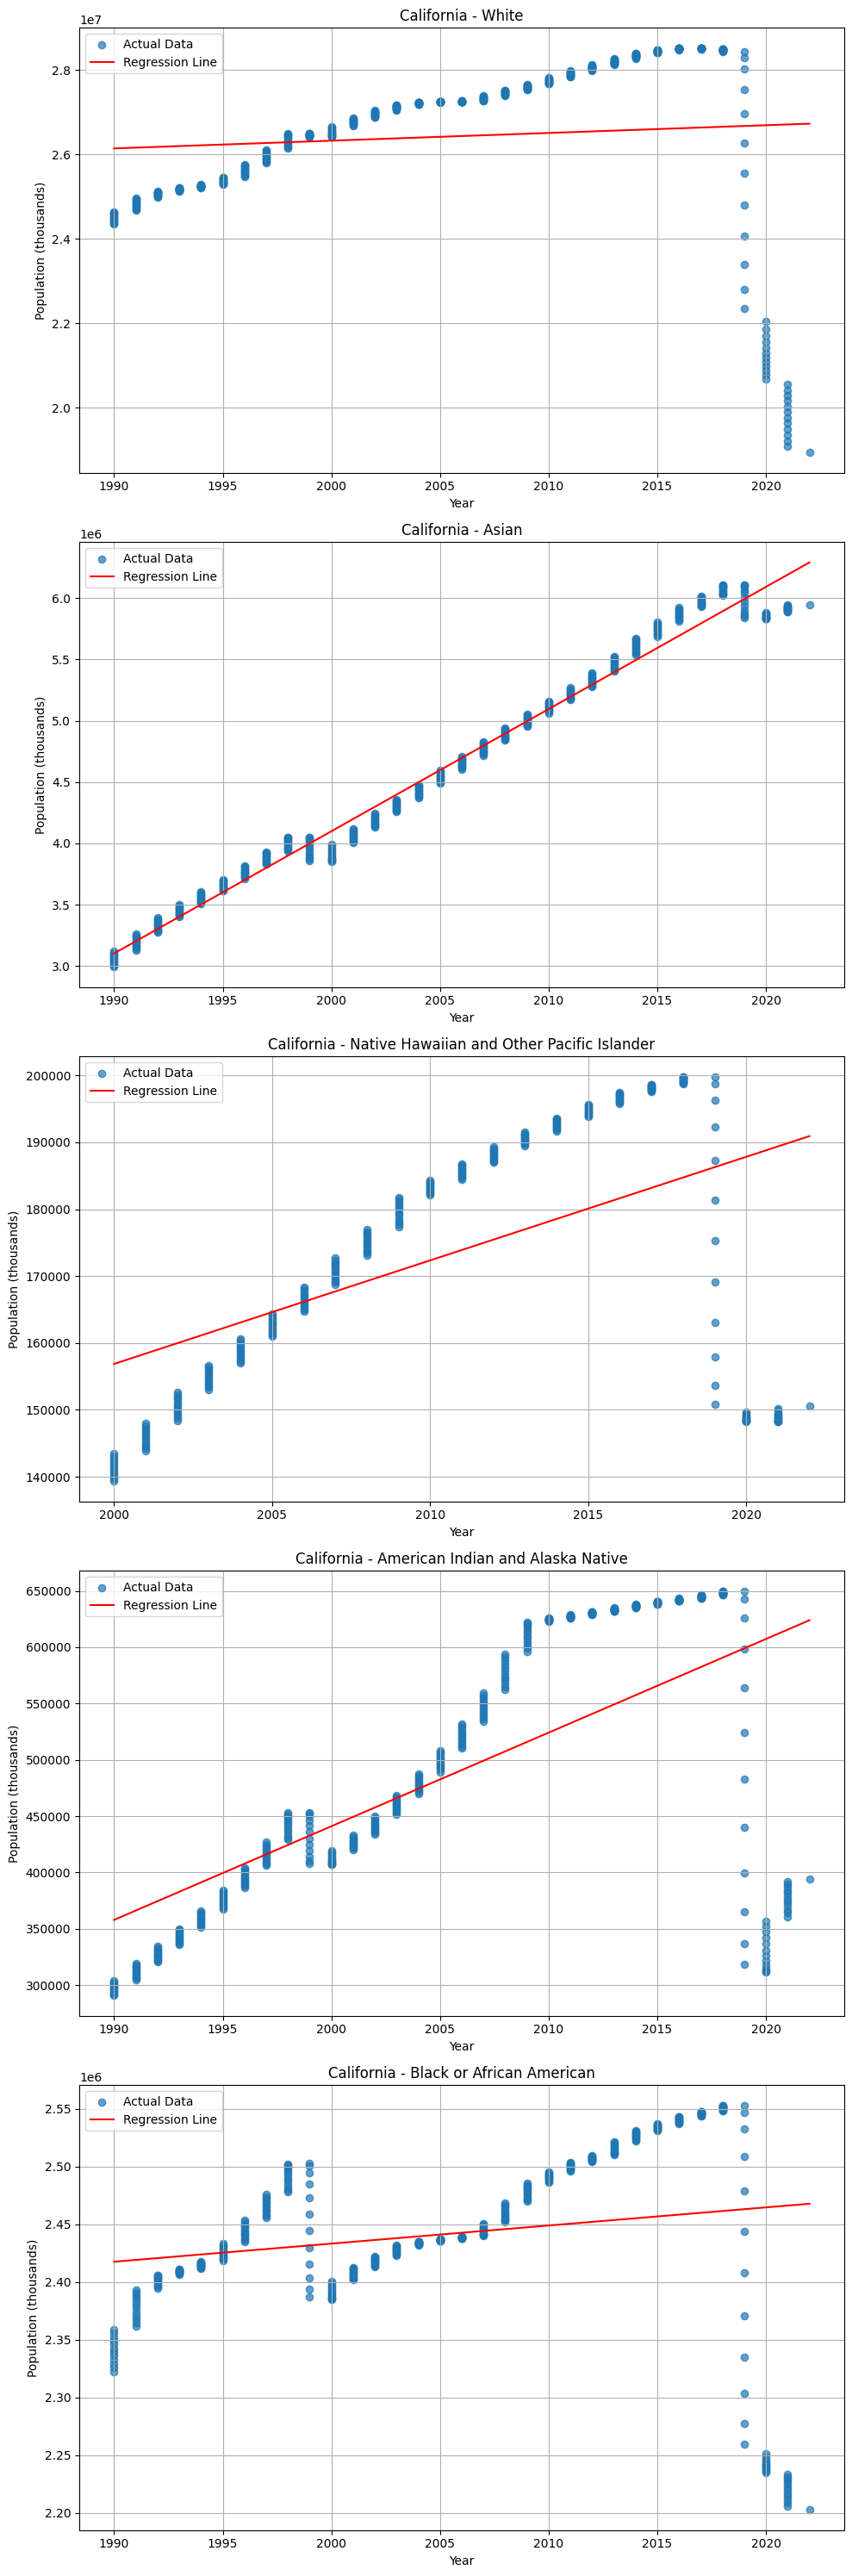

Plotting results for Alabama...


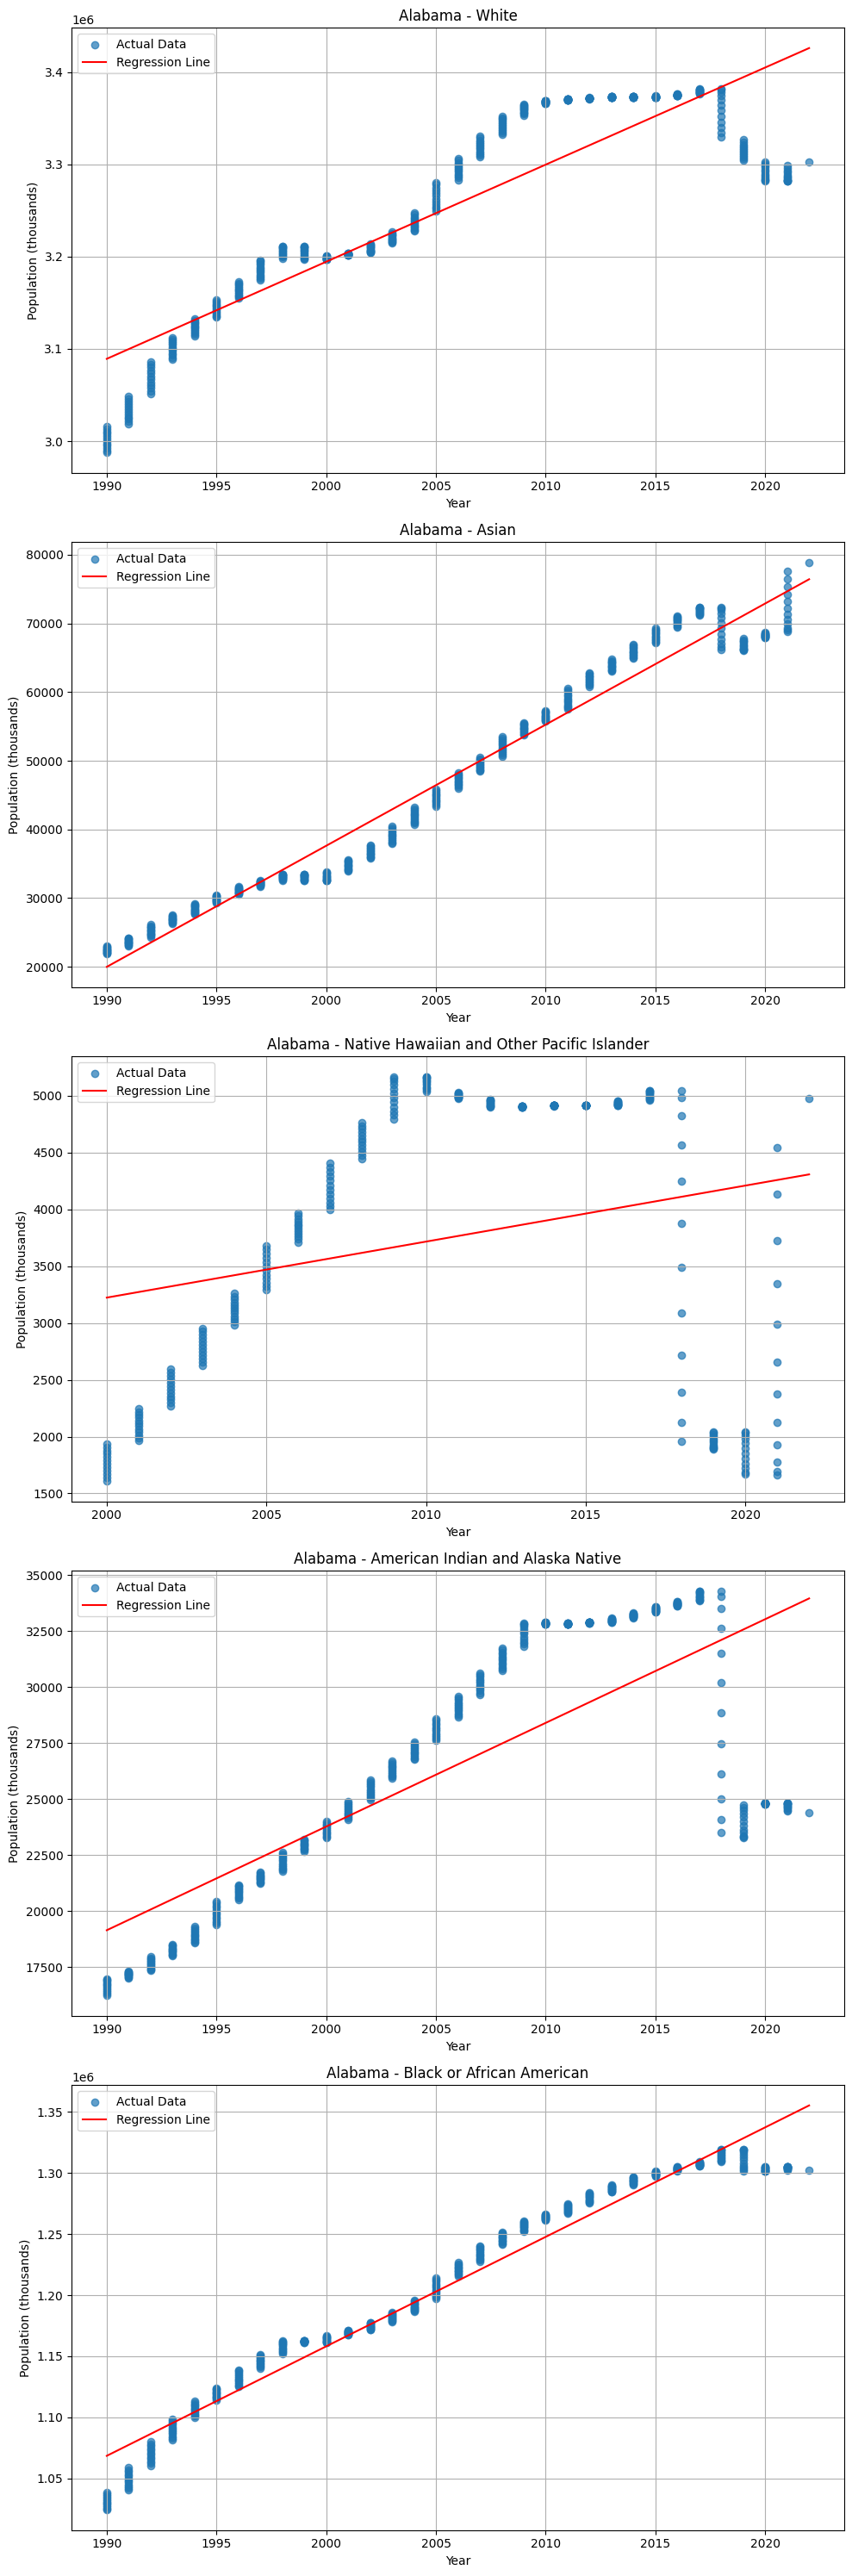

Plotting results for Texas...


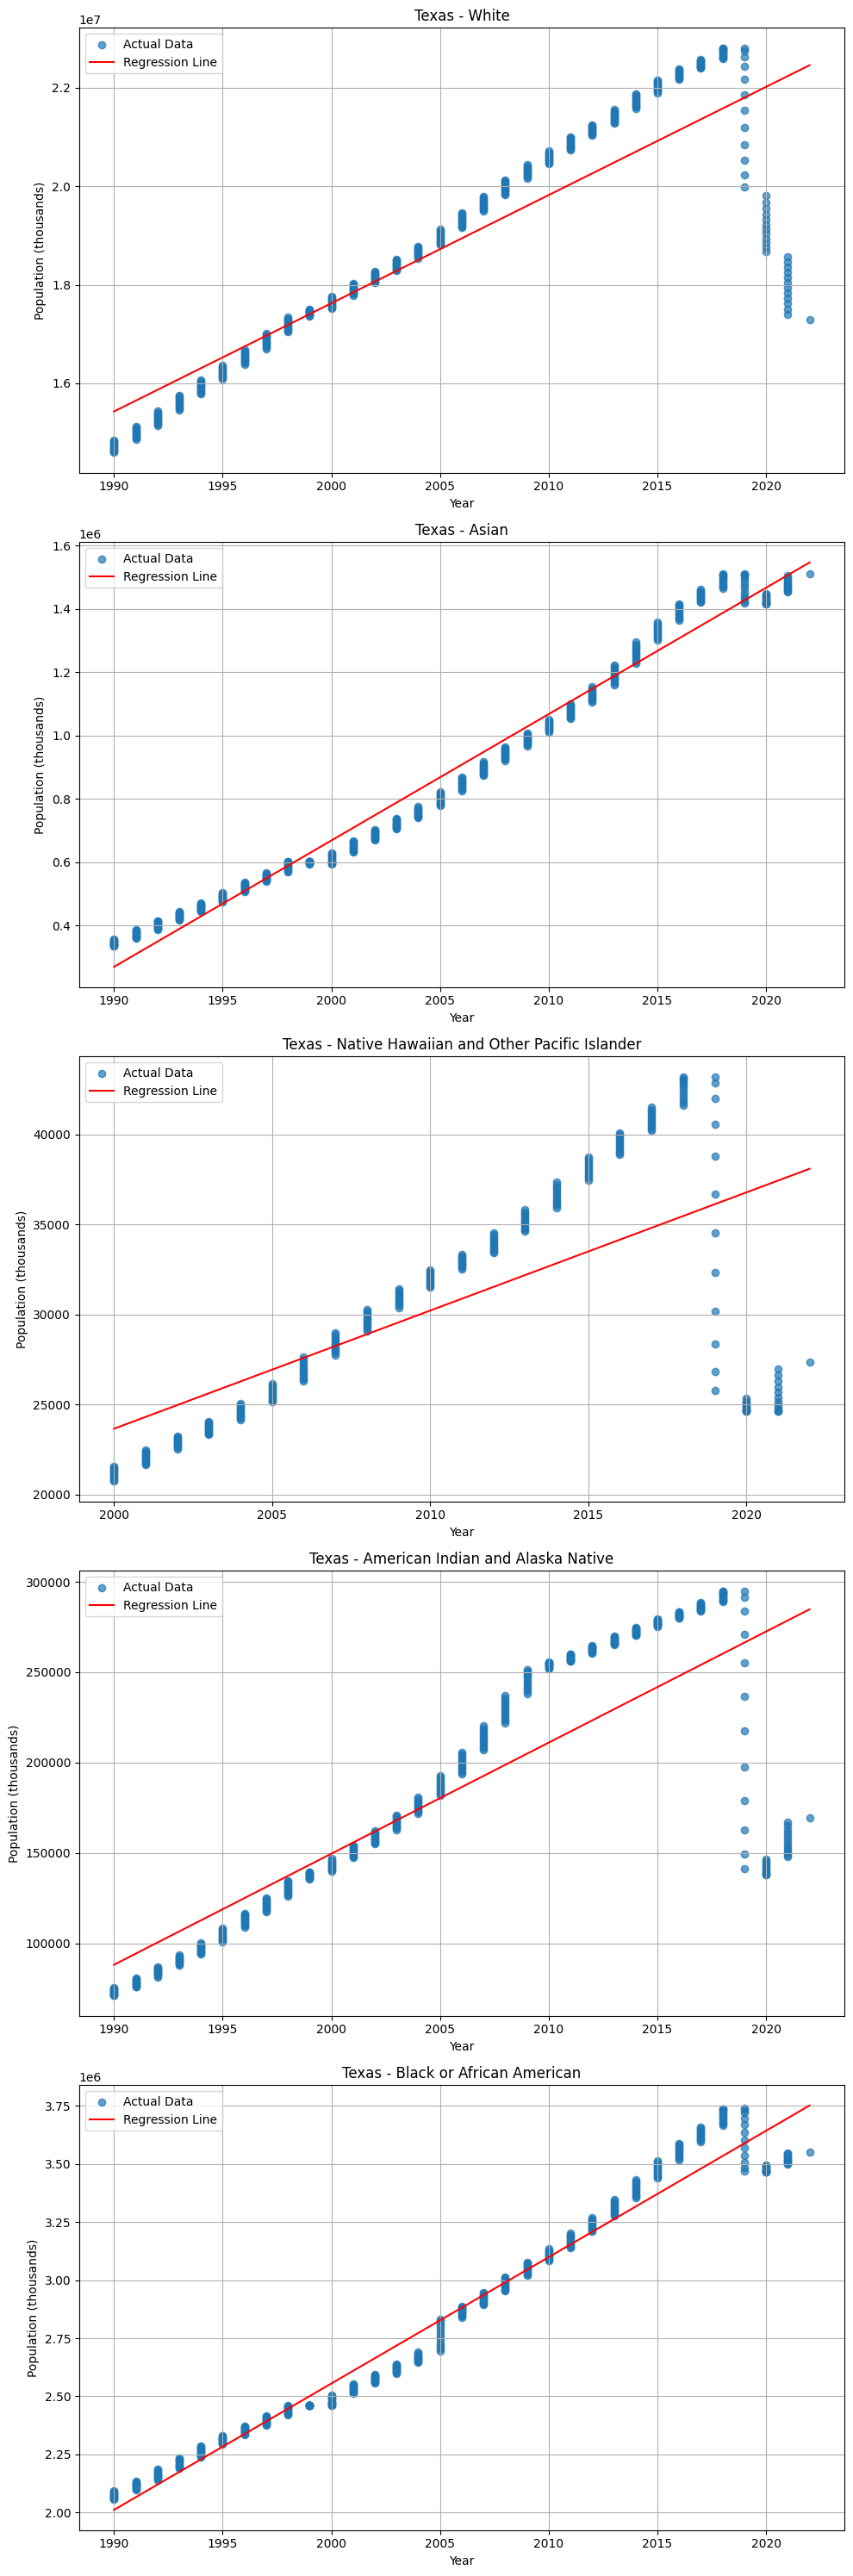

Plotting results for California...


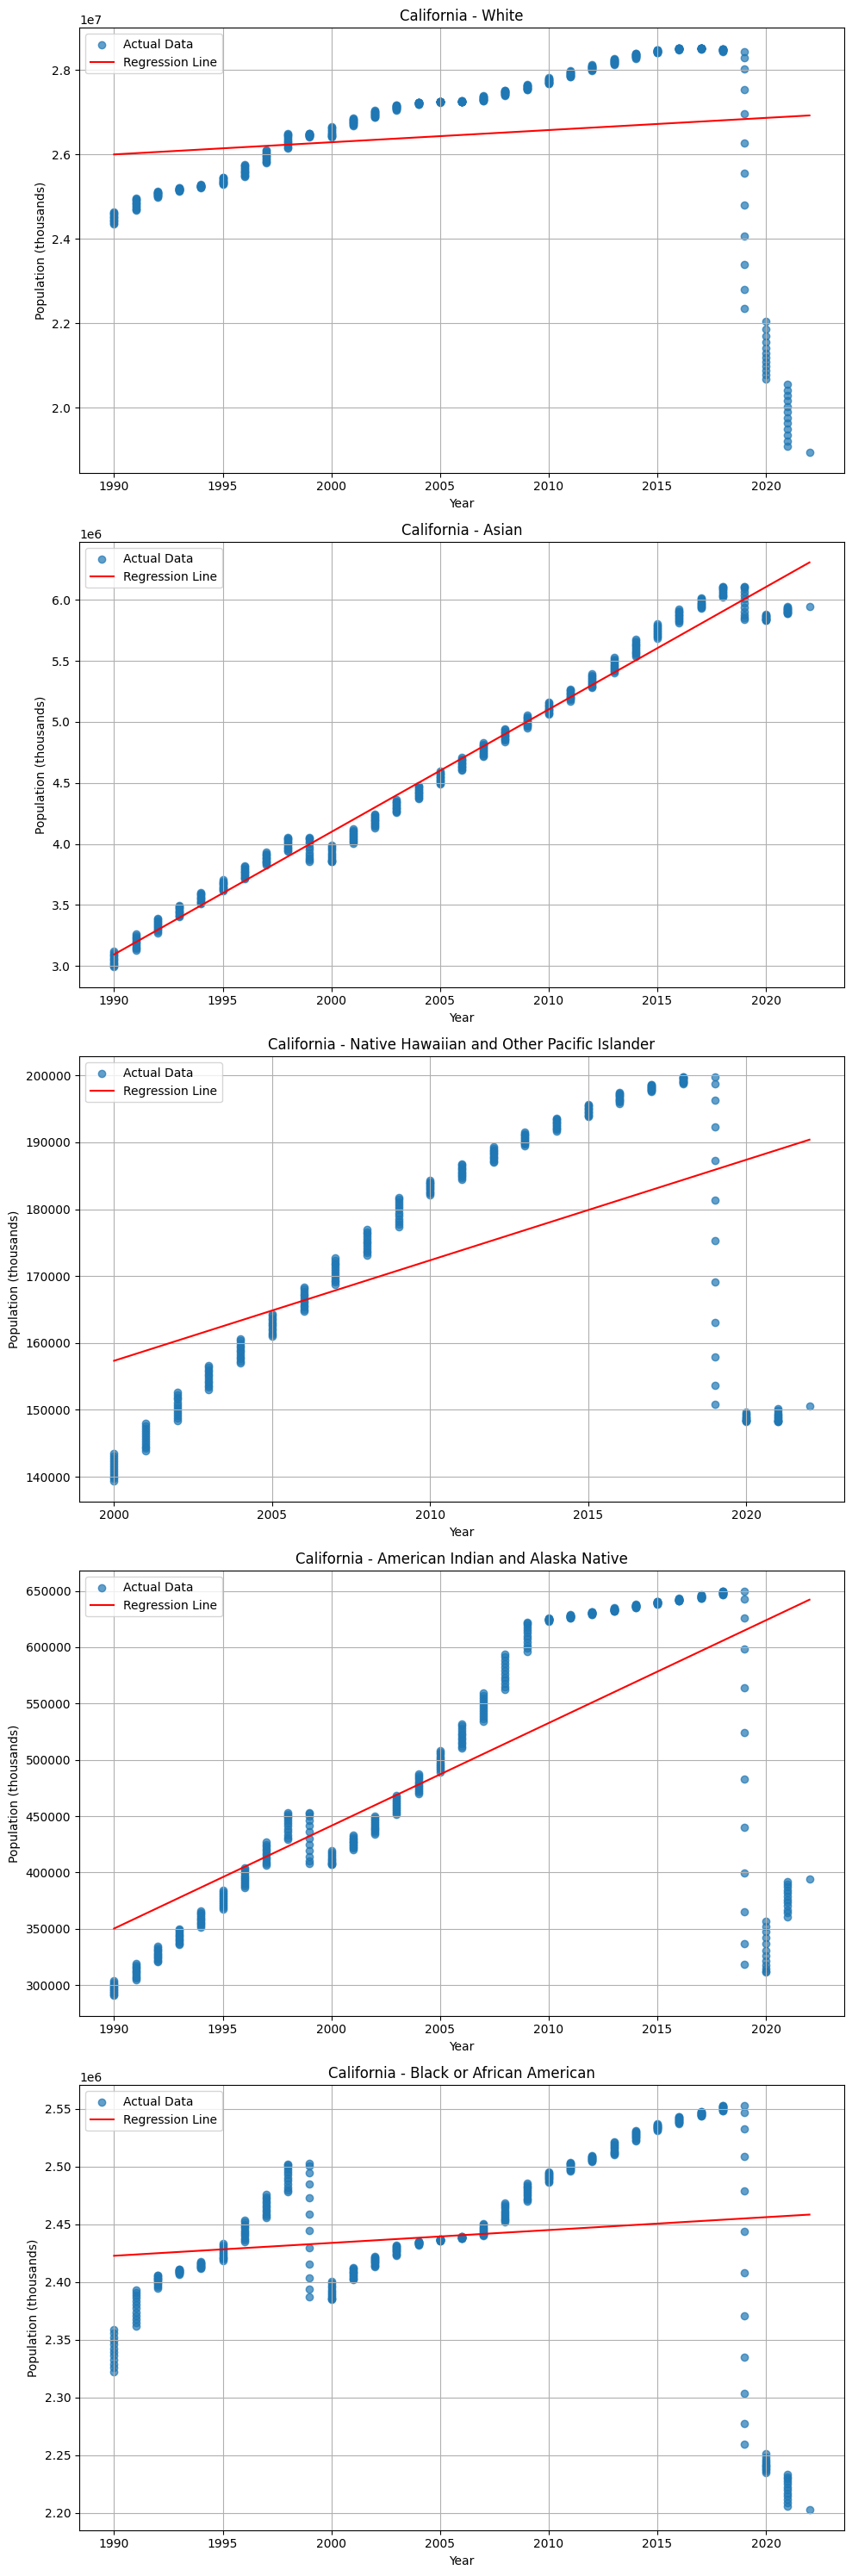

Plotting results for Alabama...


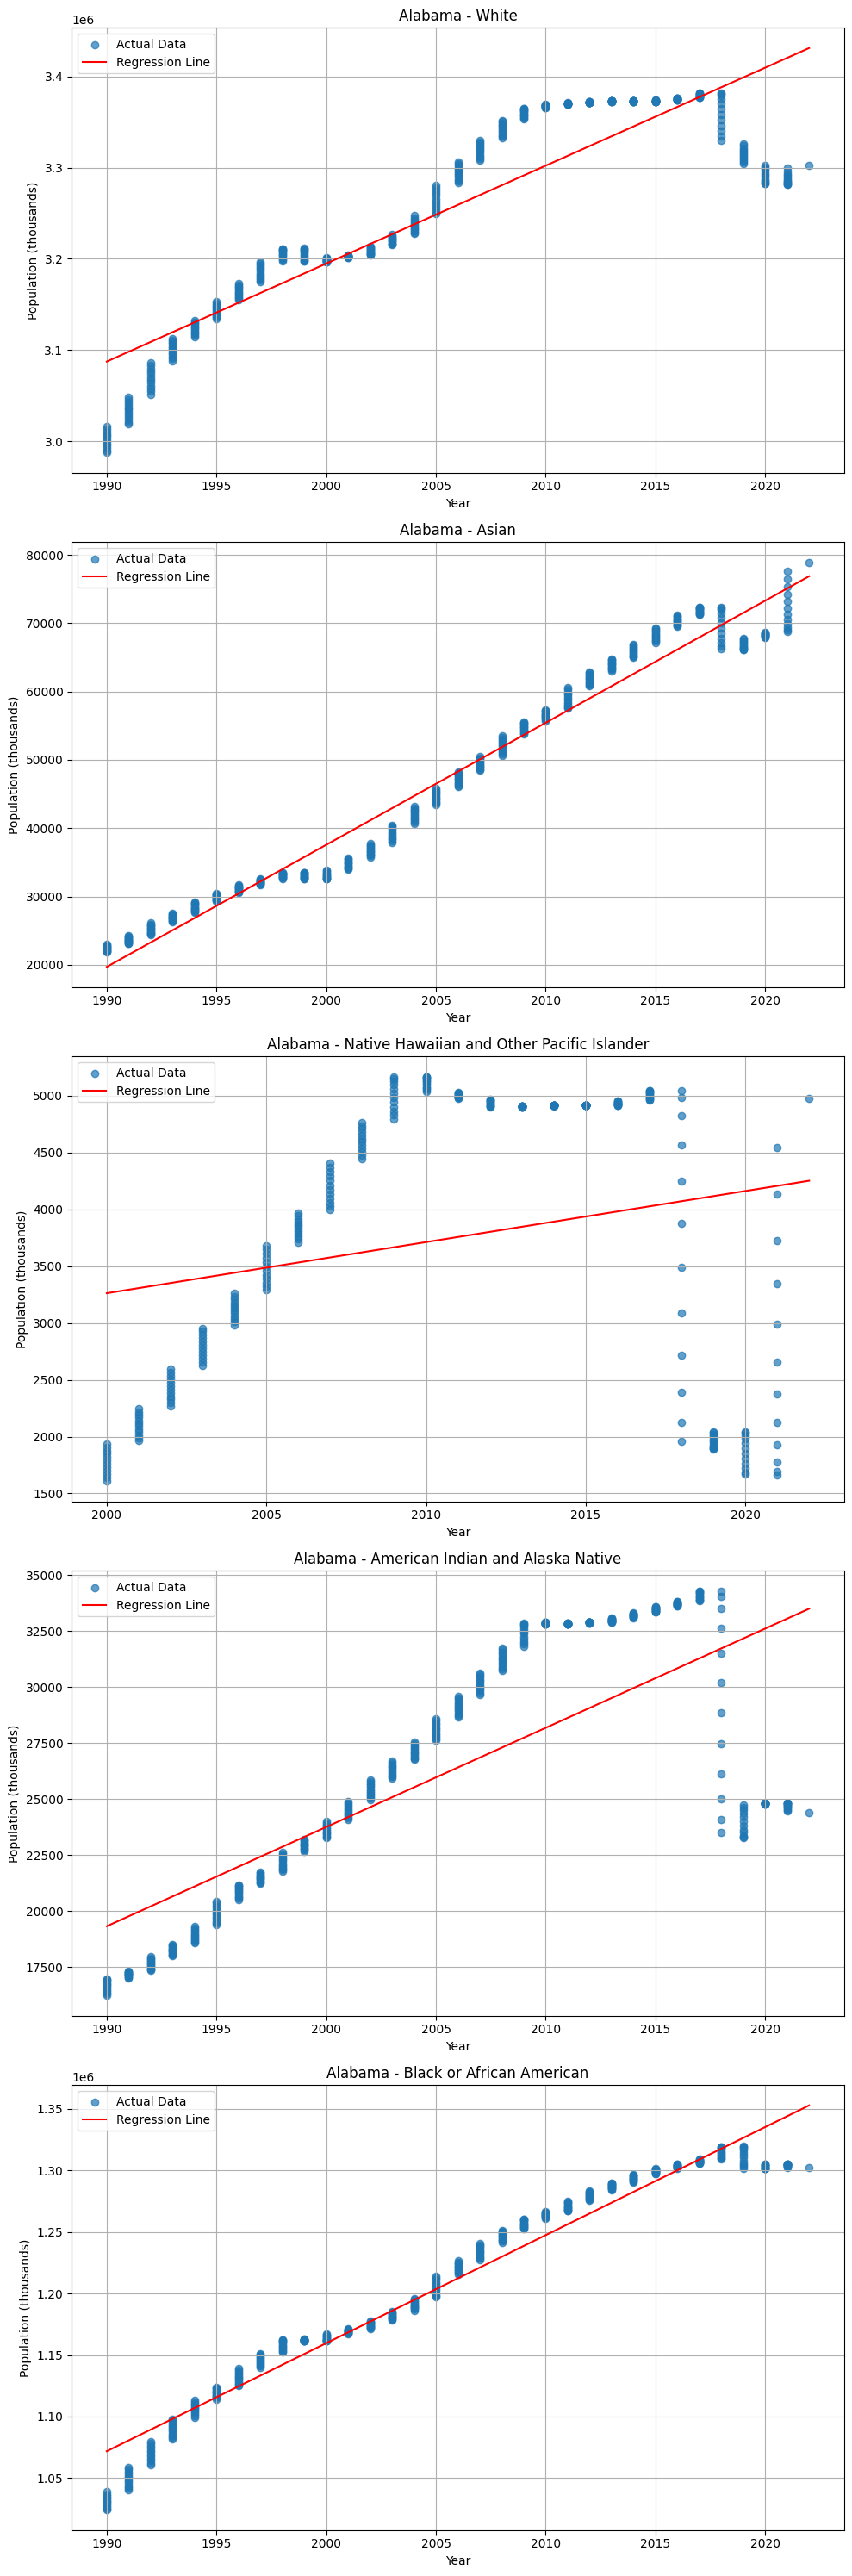

Plotting results for Texas...


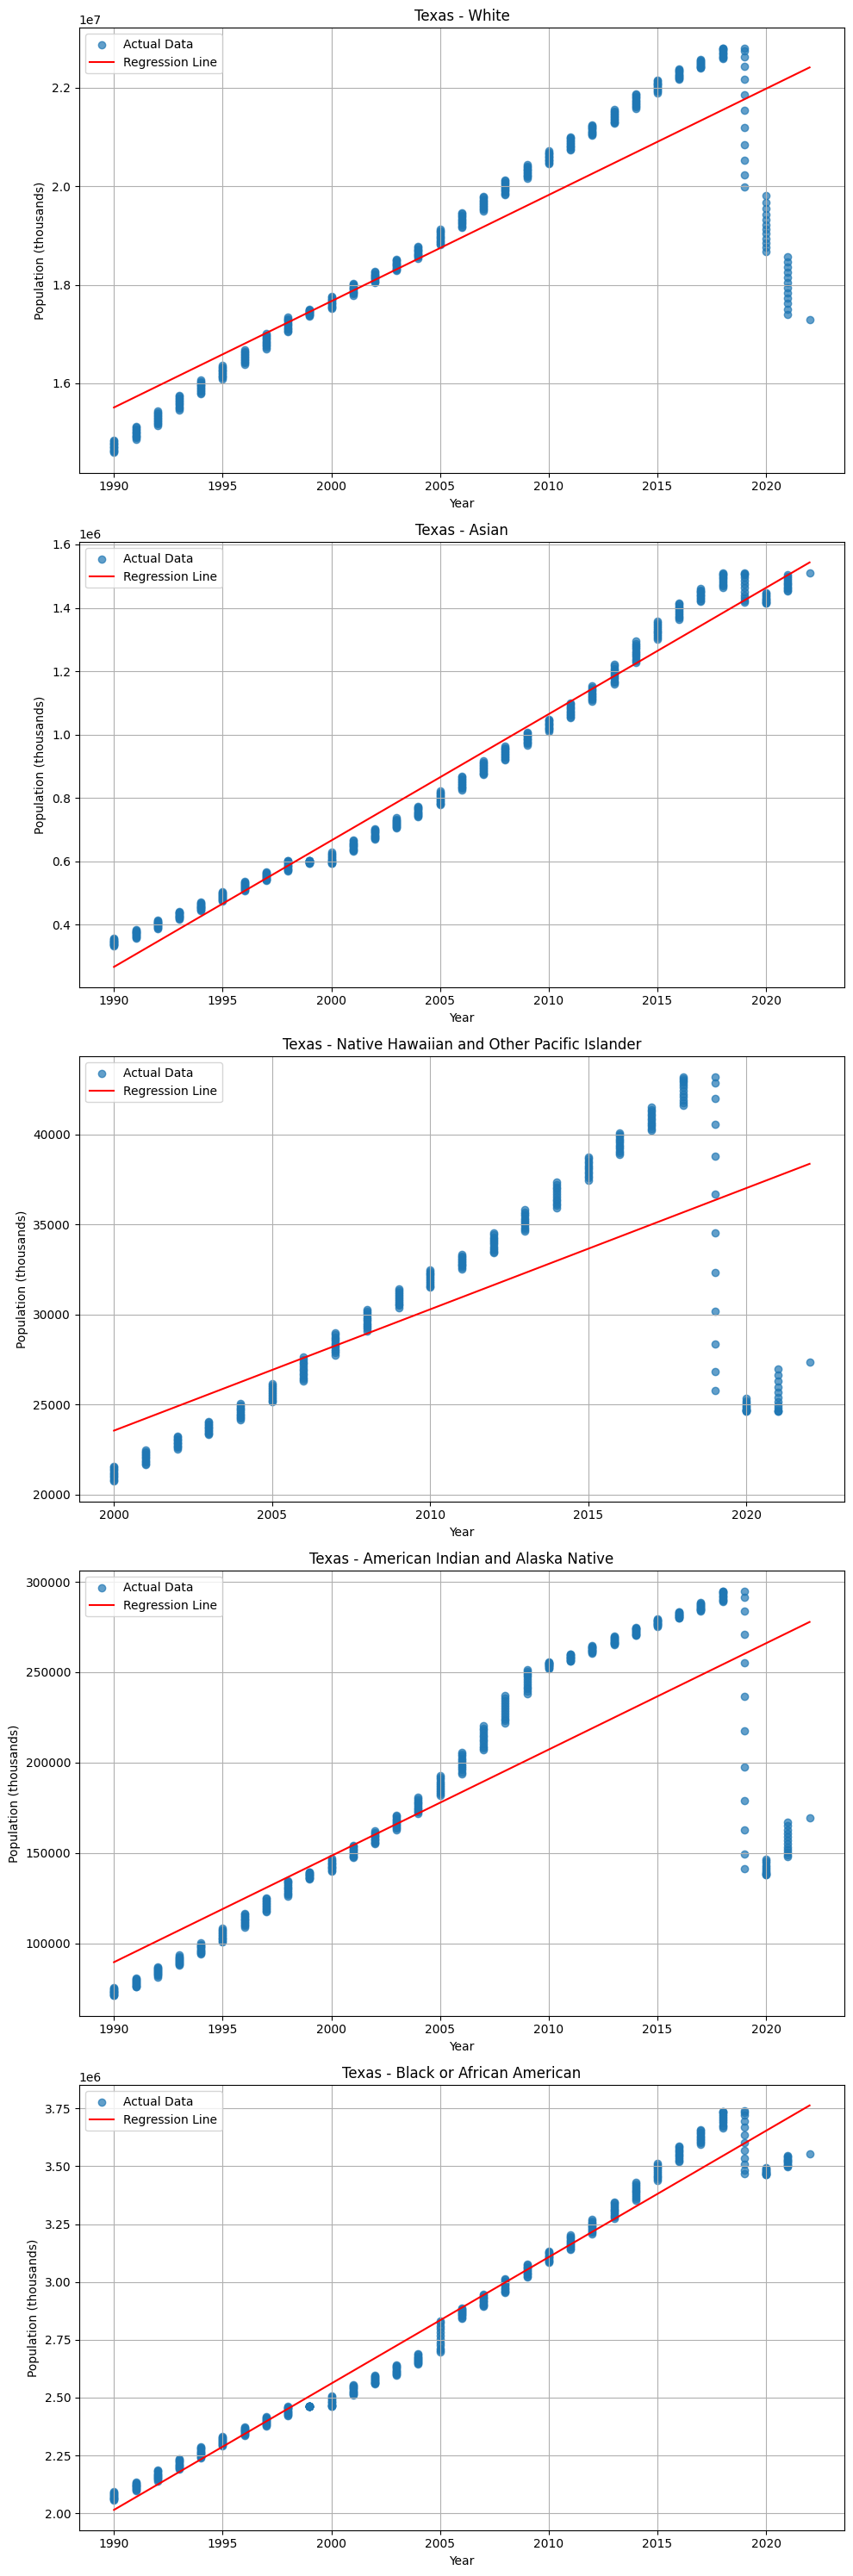

Plotting results for NewYork...


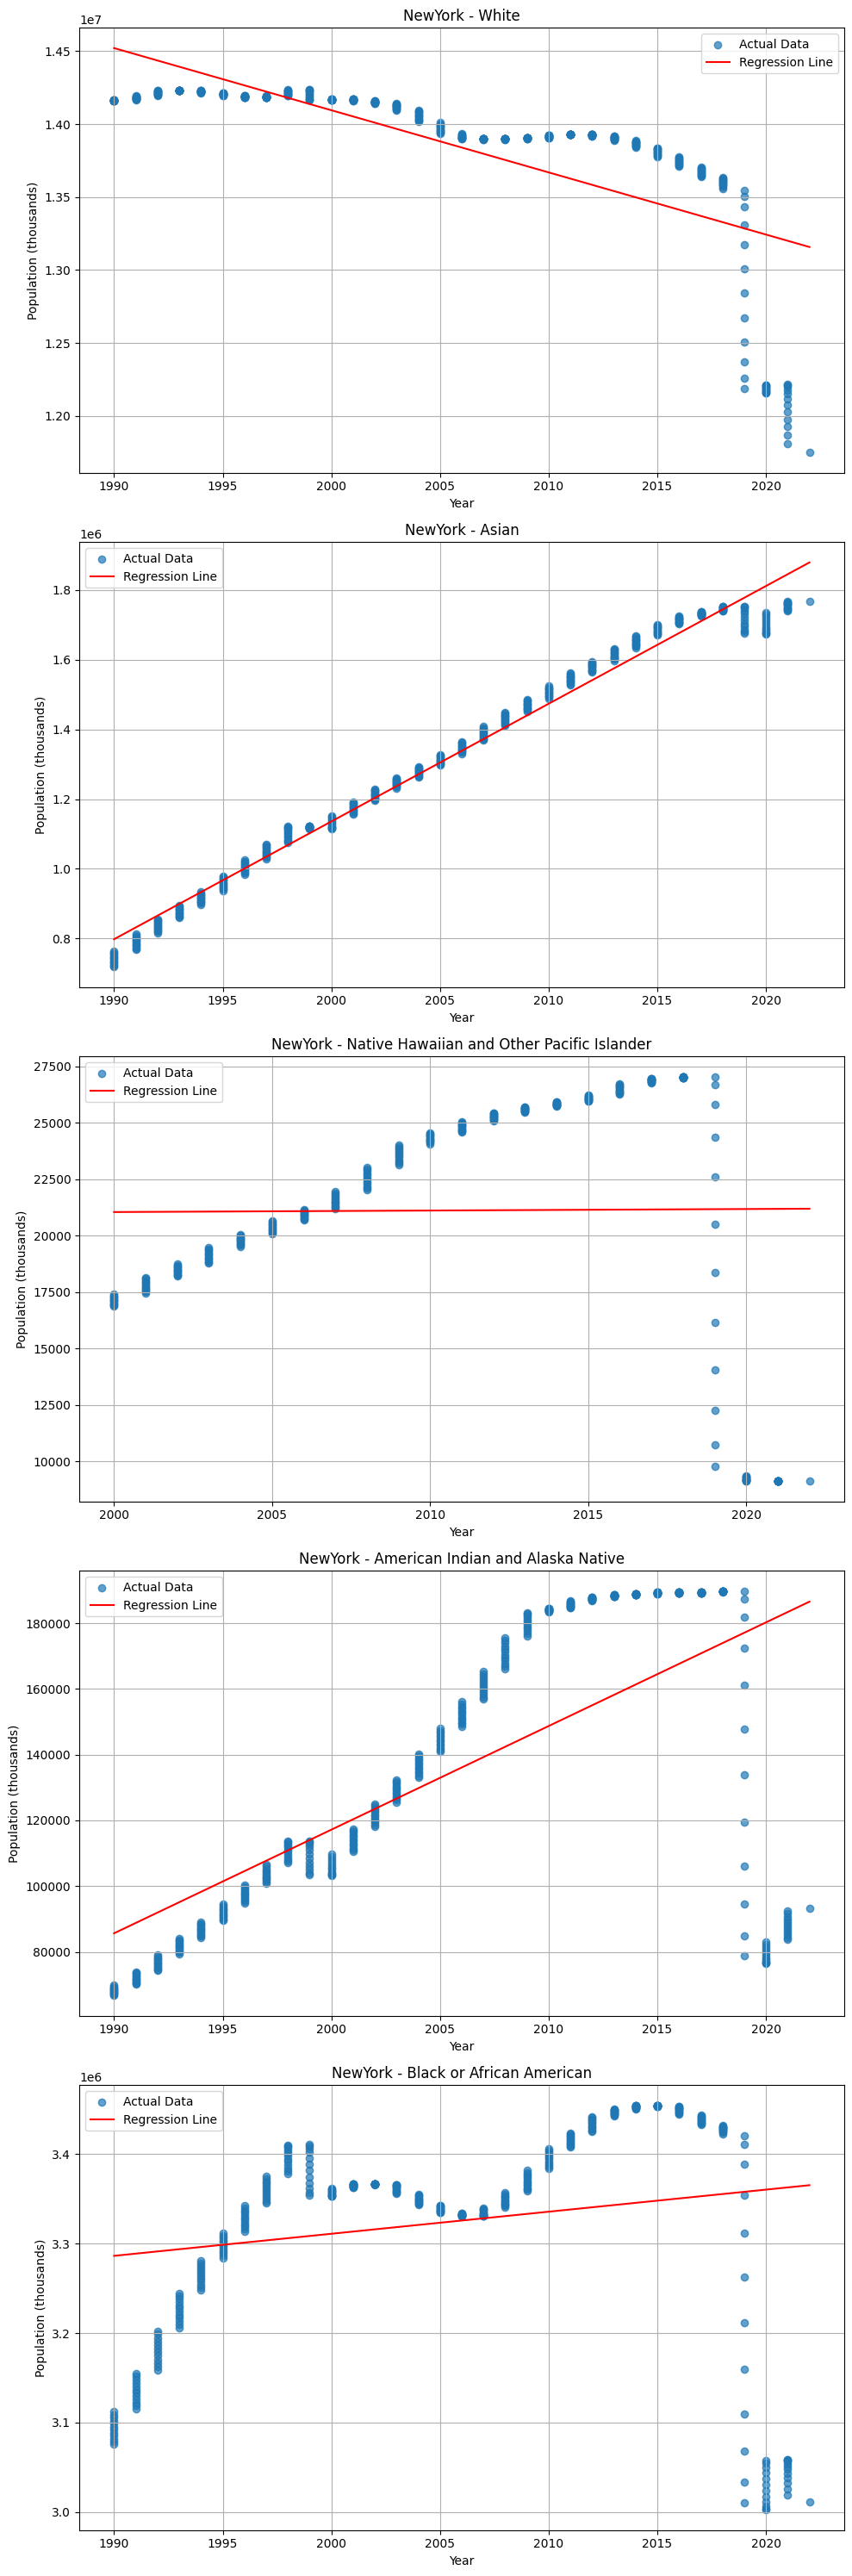

Plotting results for California...


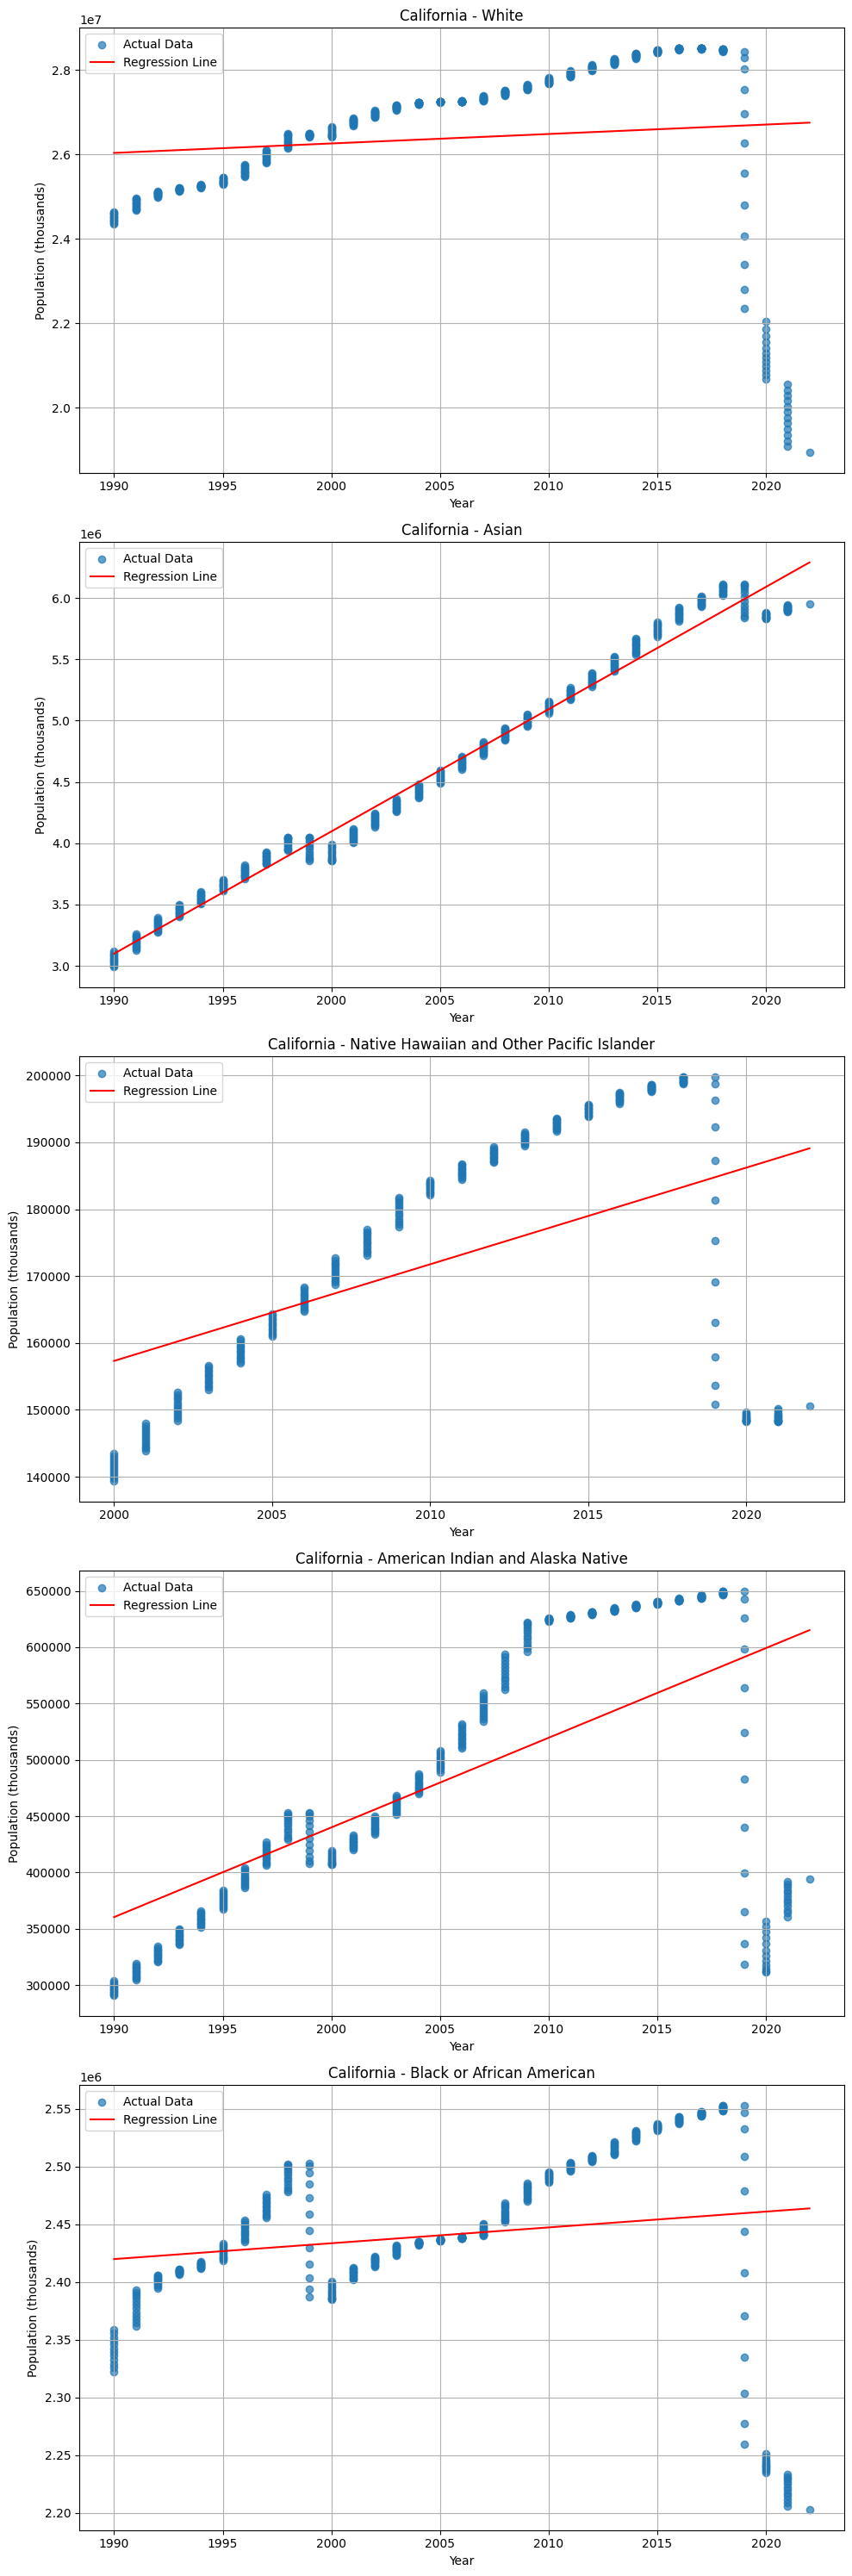

Plotting results for Alabama...


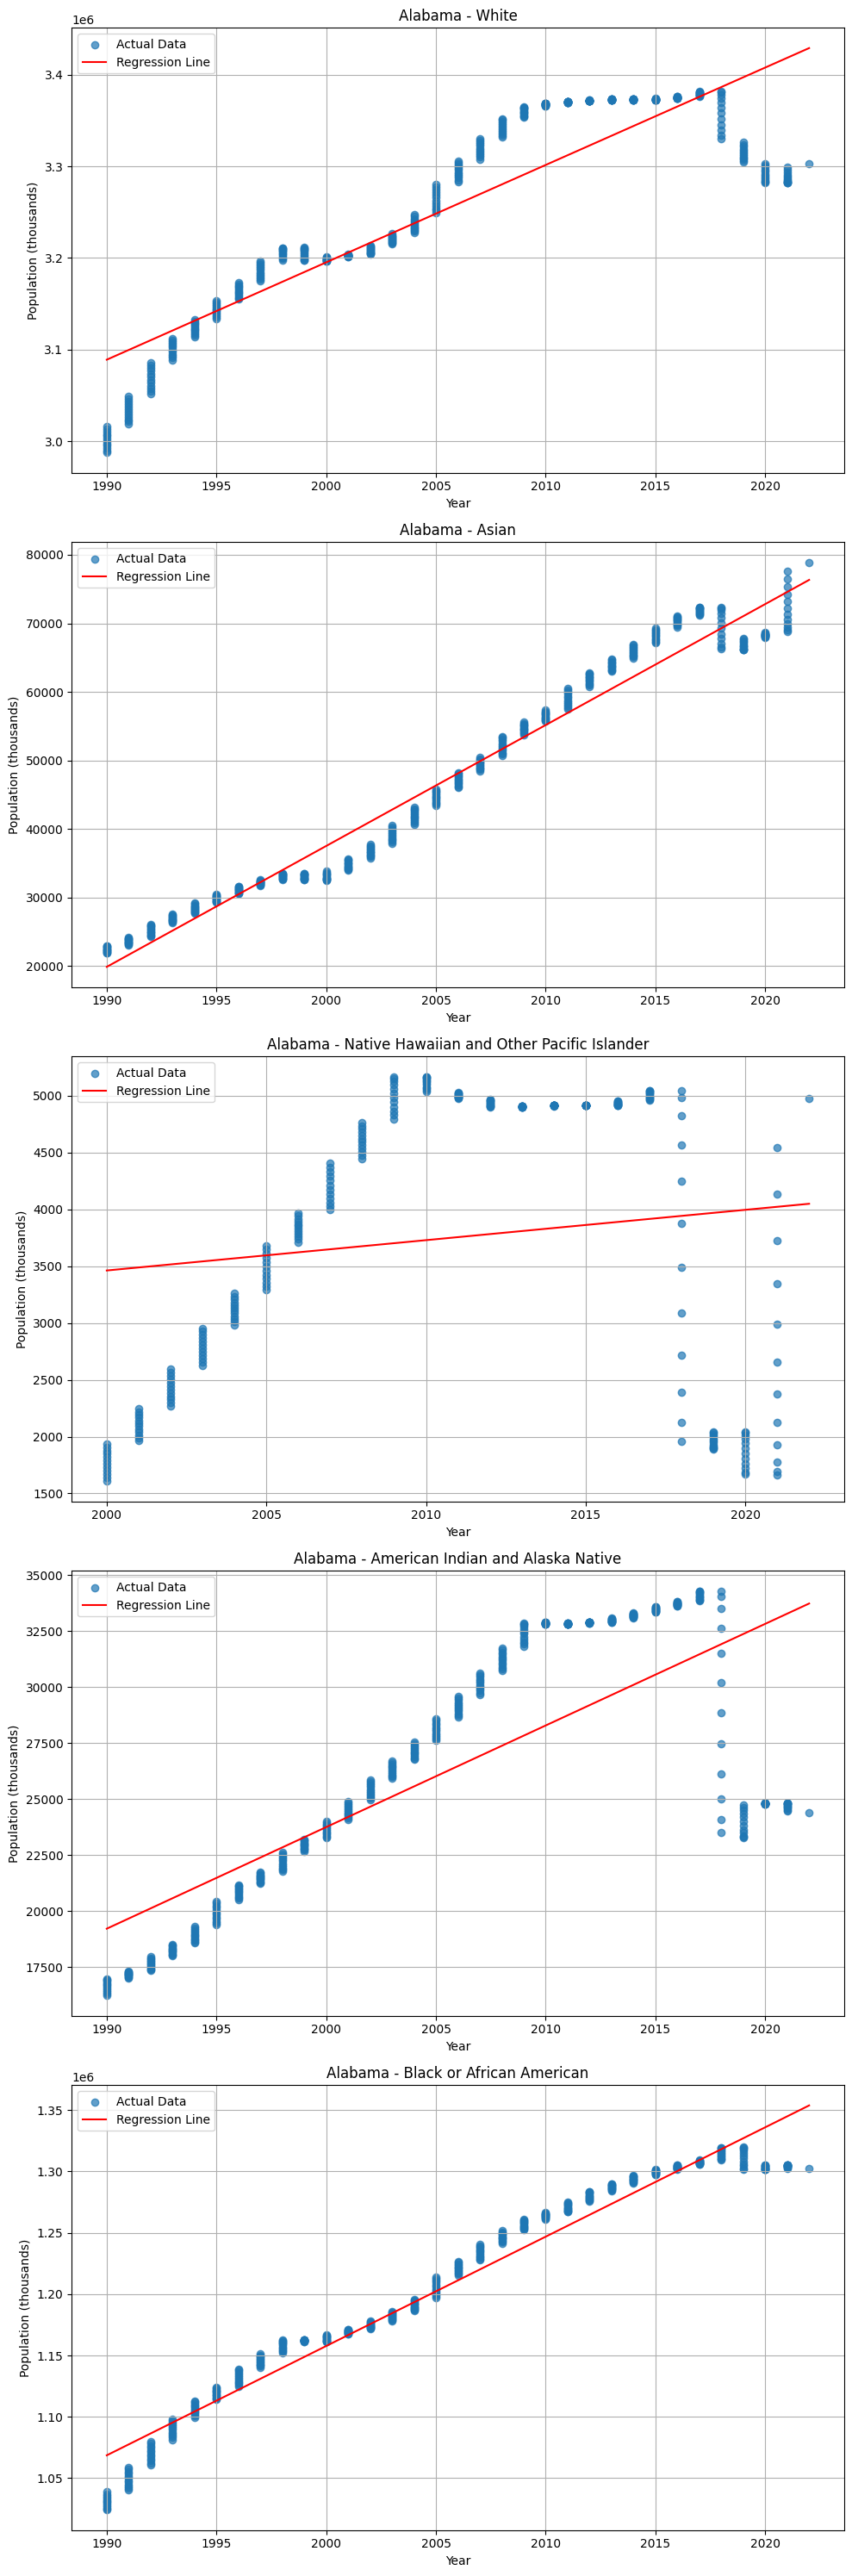

Plotting results for Texas...


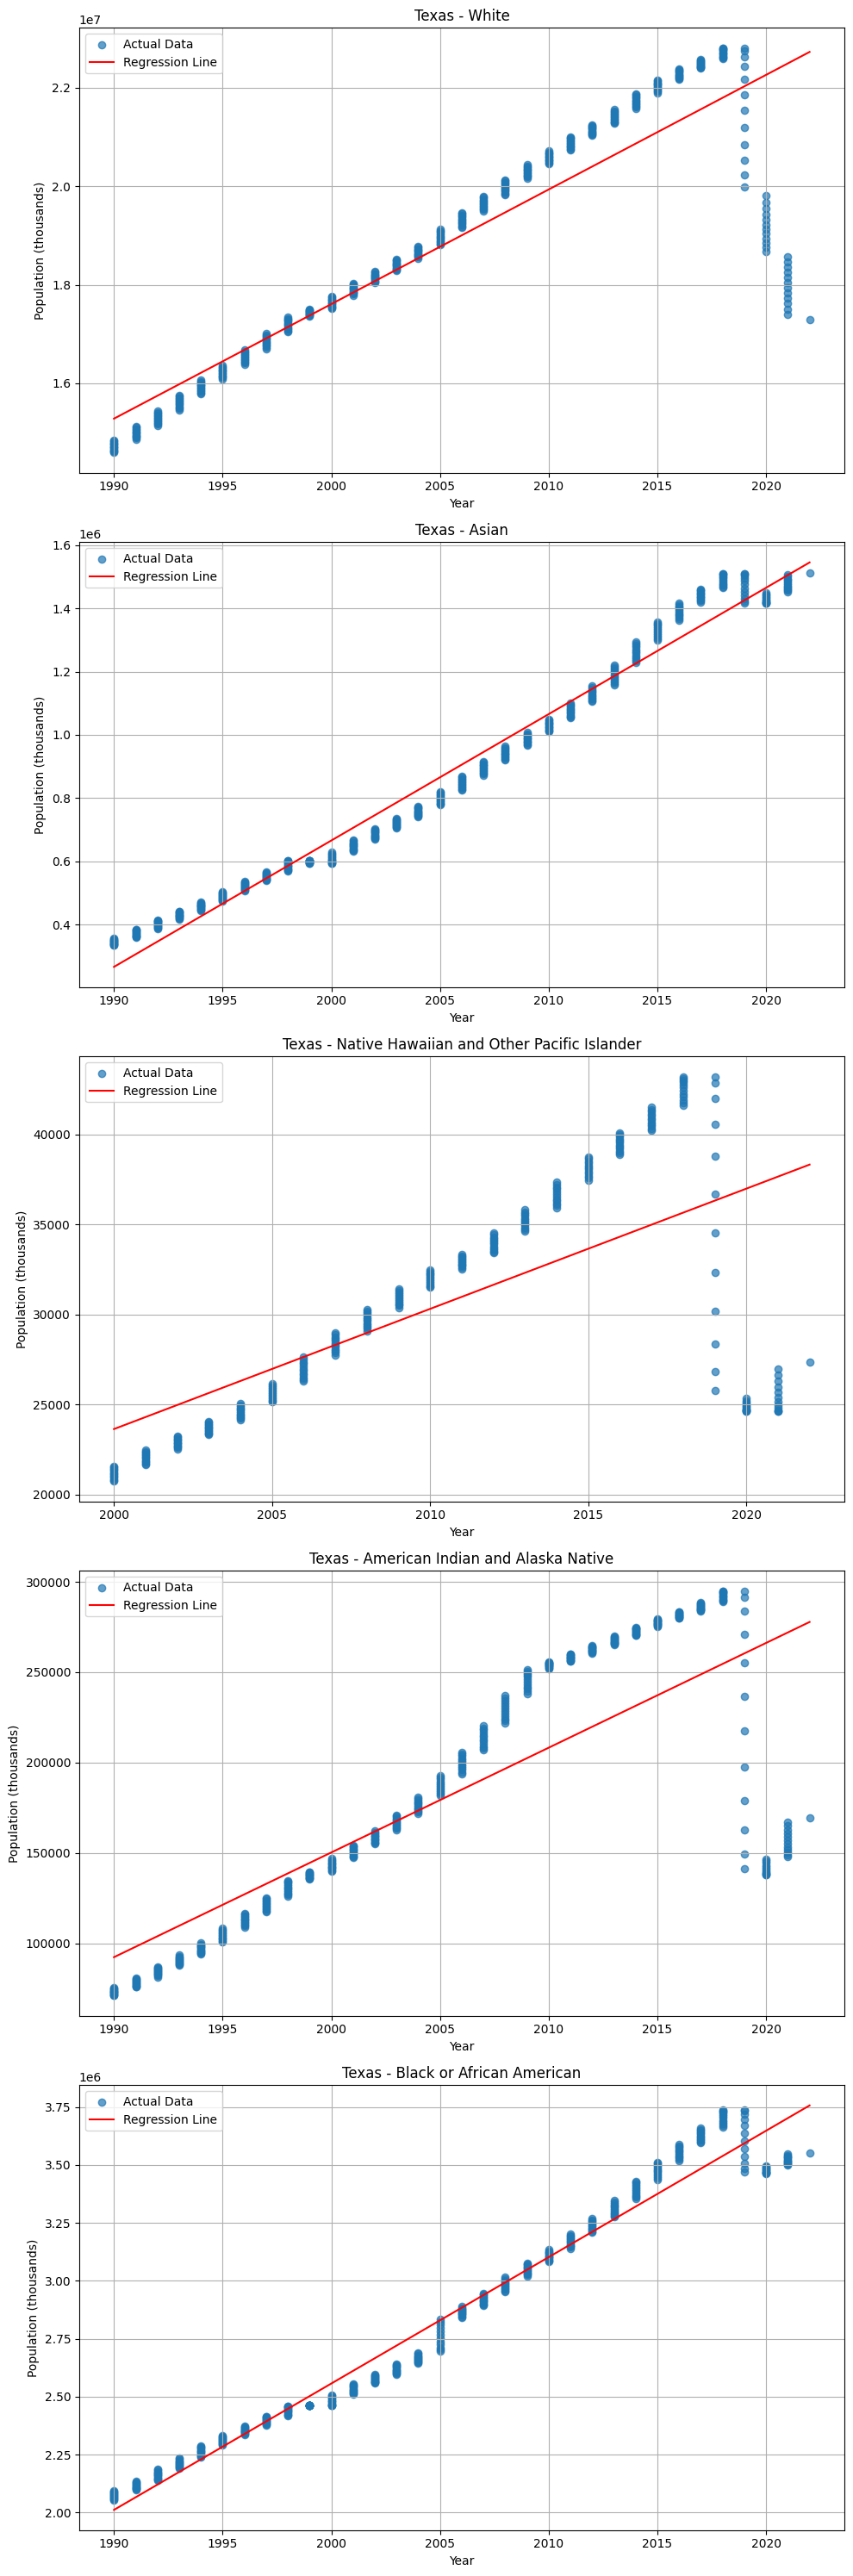

Plotting results for NewYork...


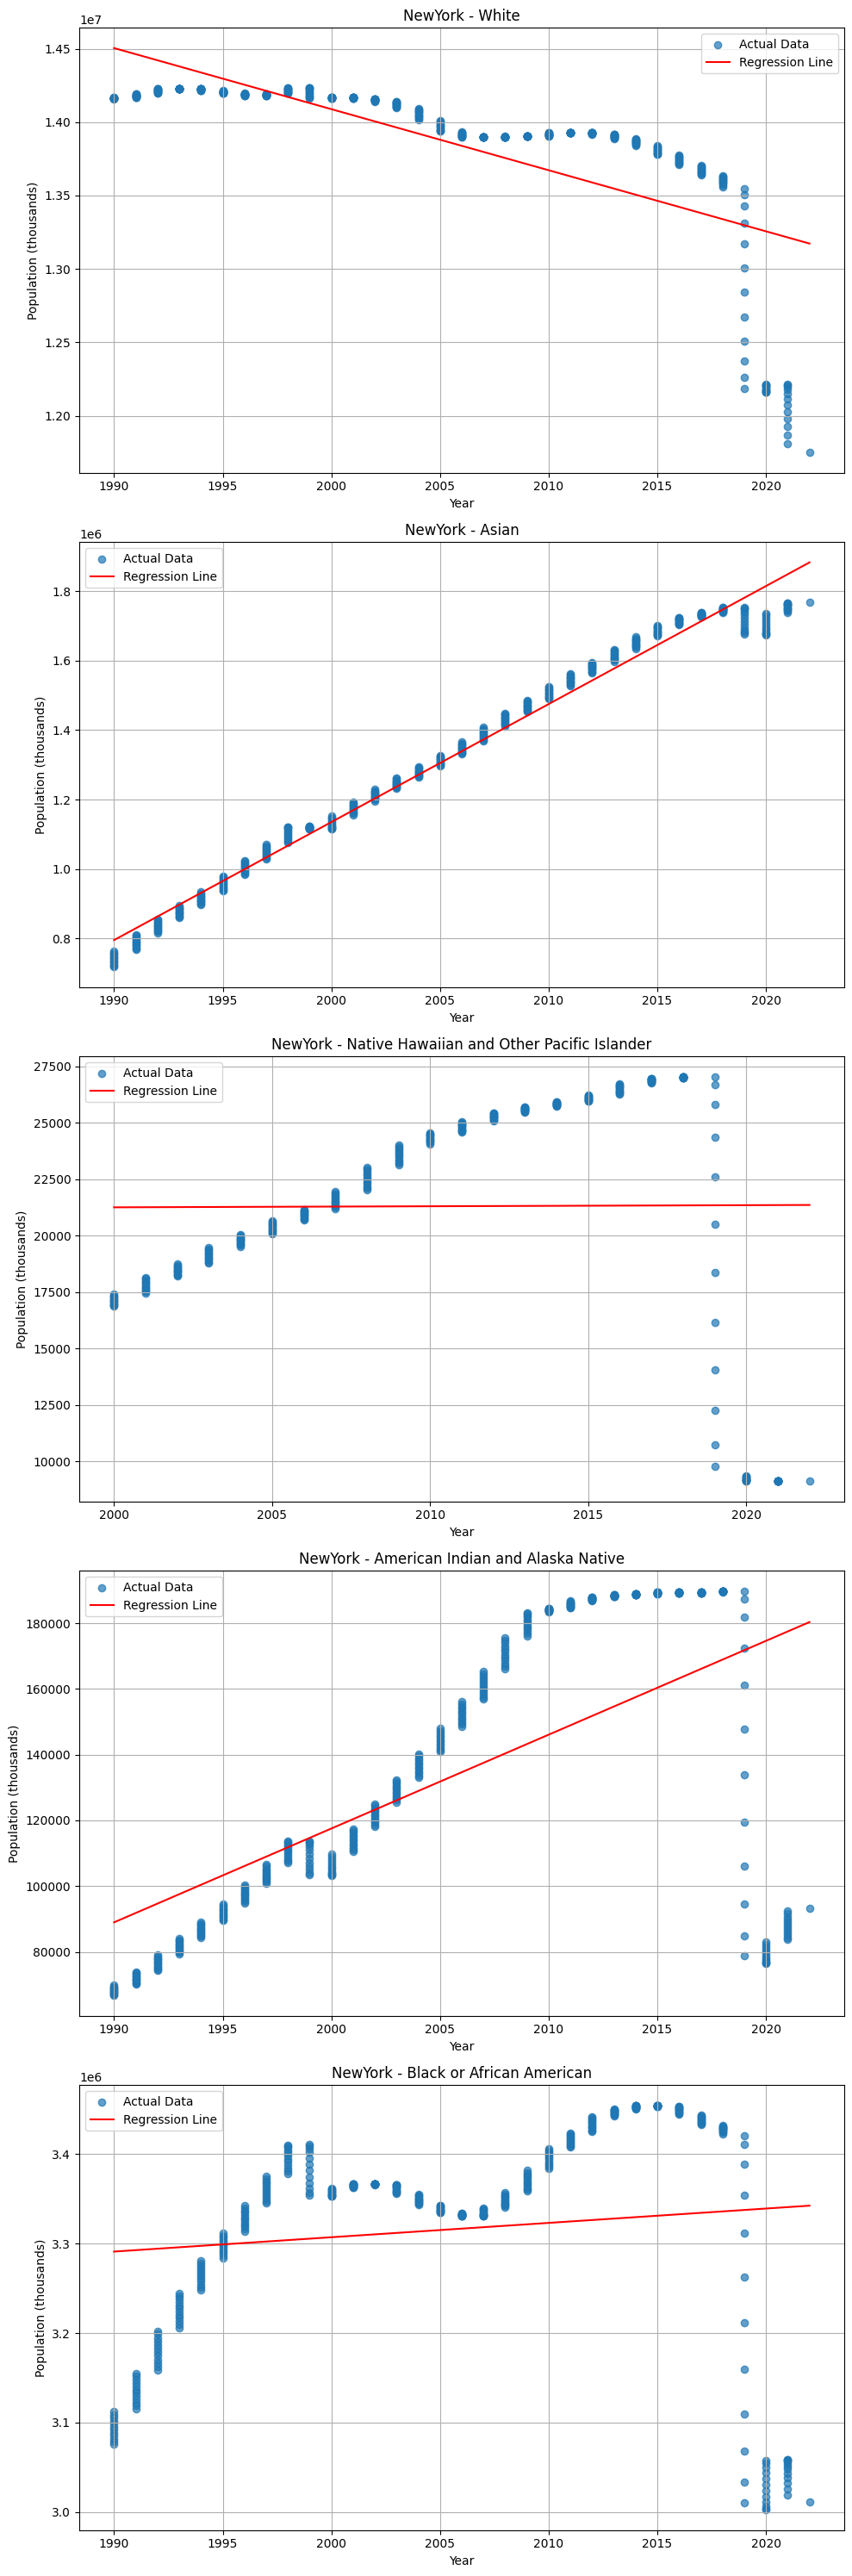

Plotting results for Hawaii...


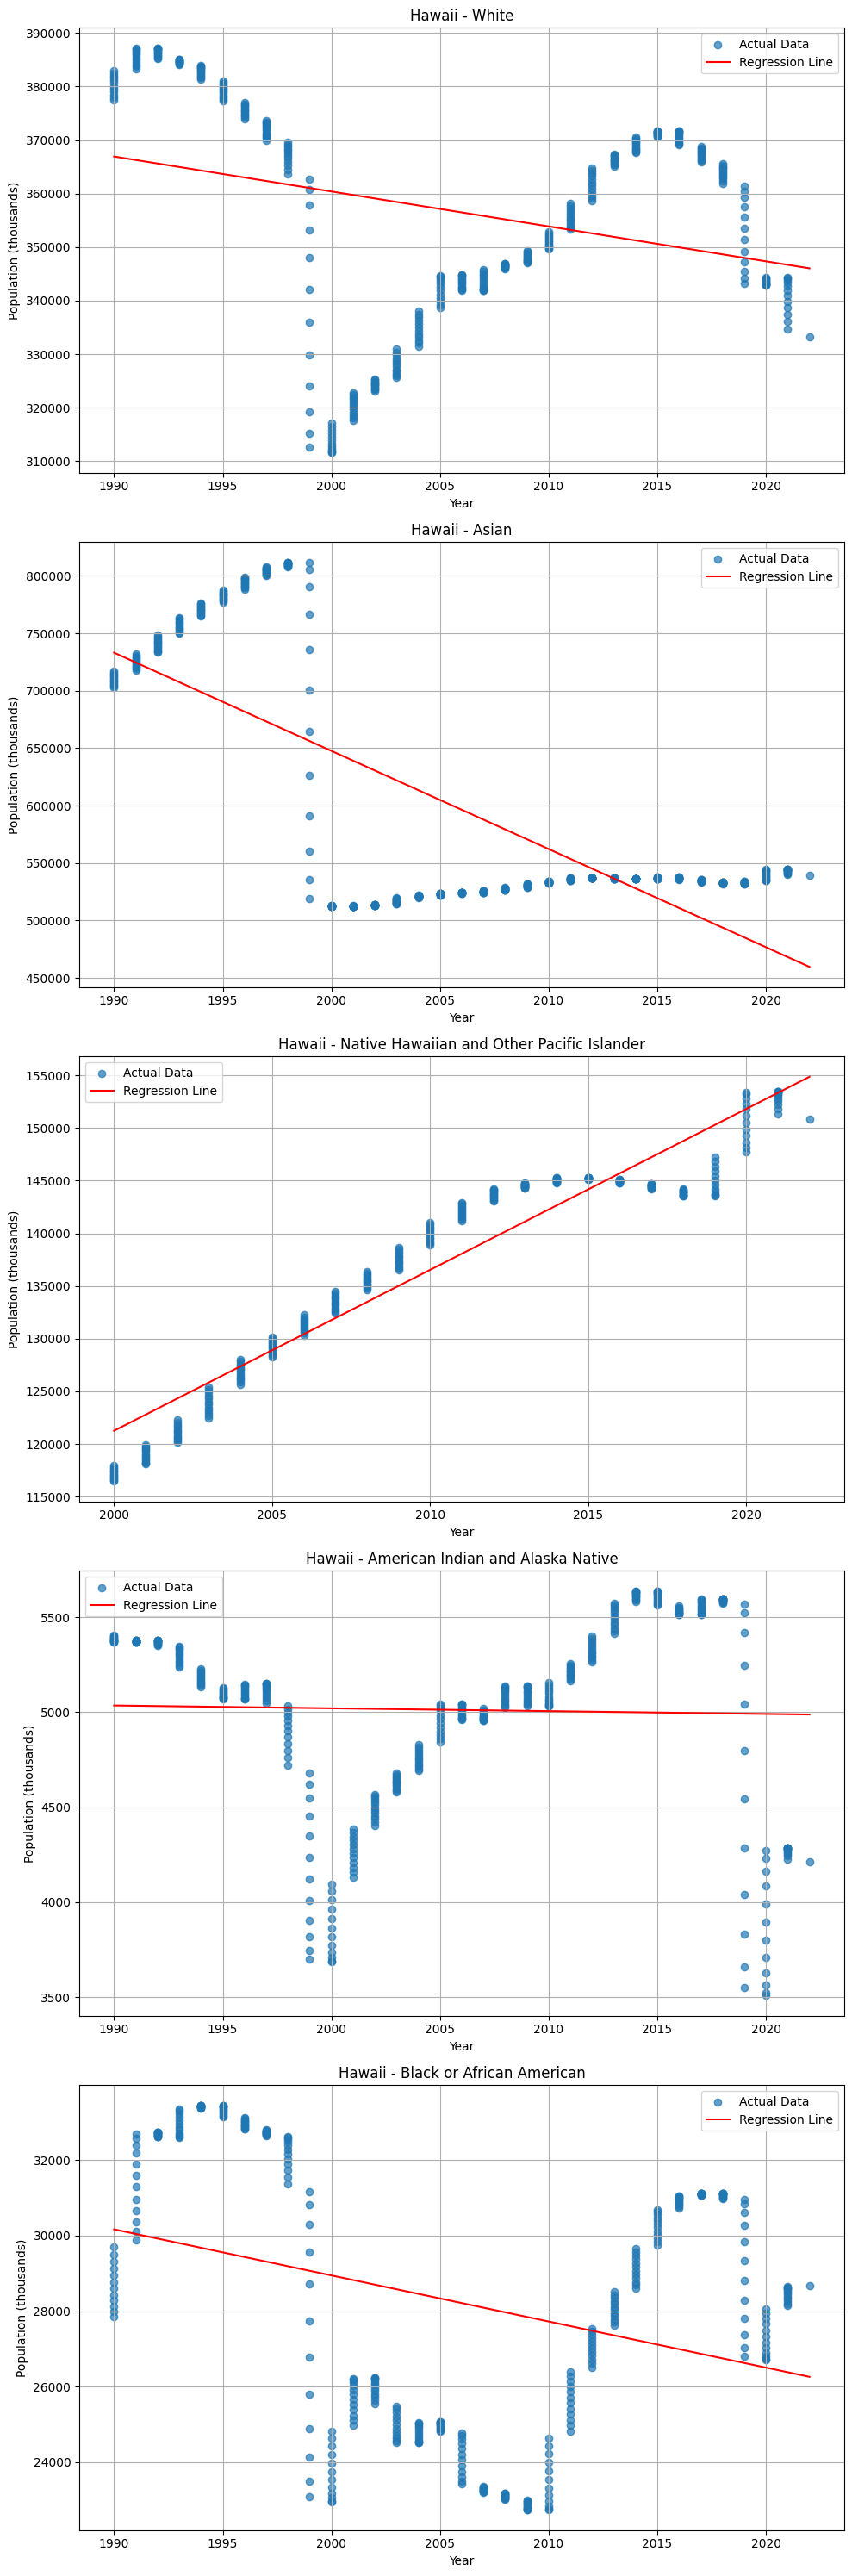

Plotting results for California...


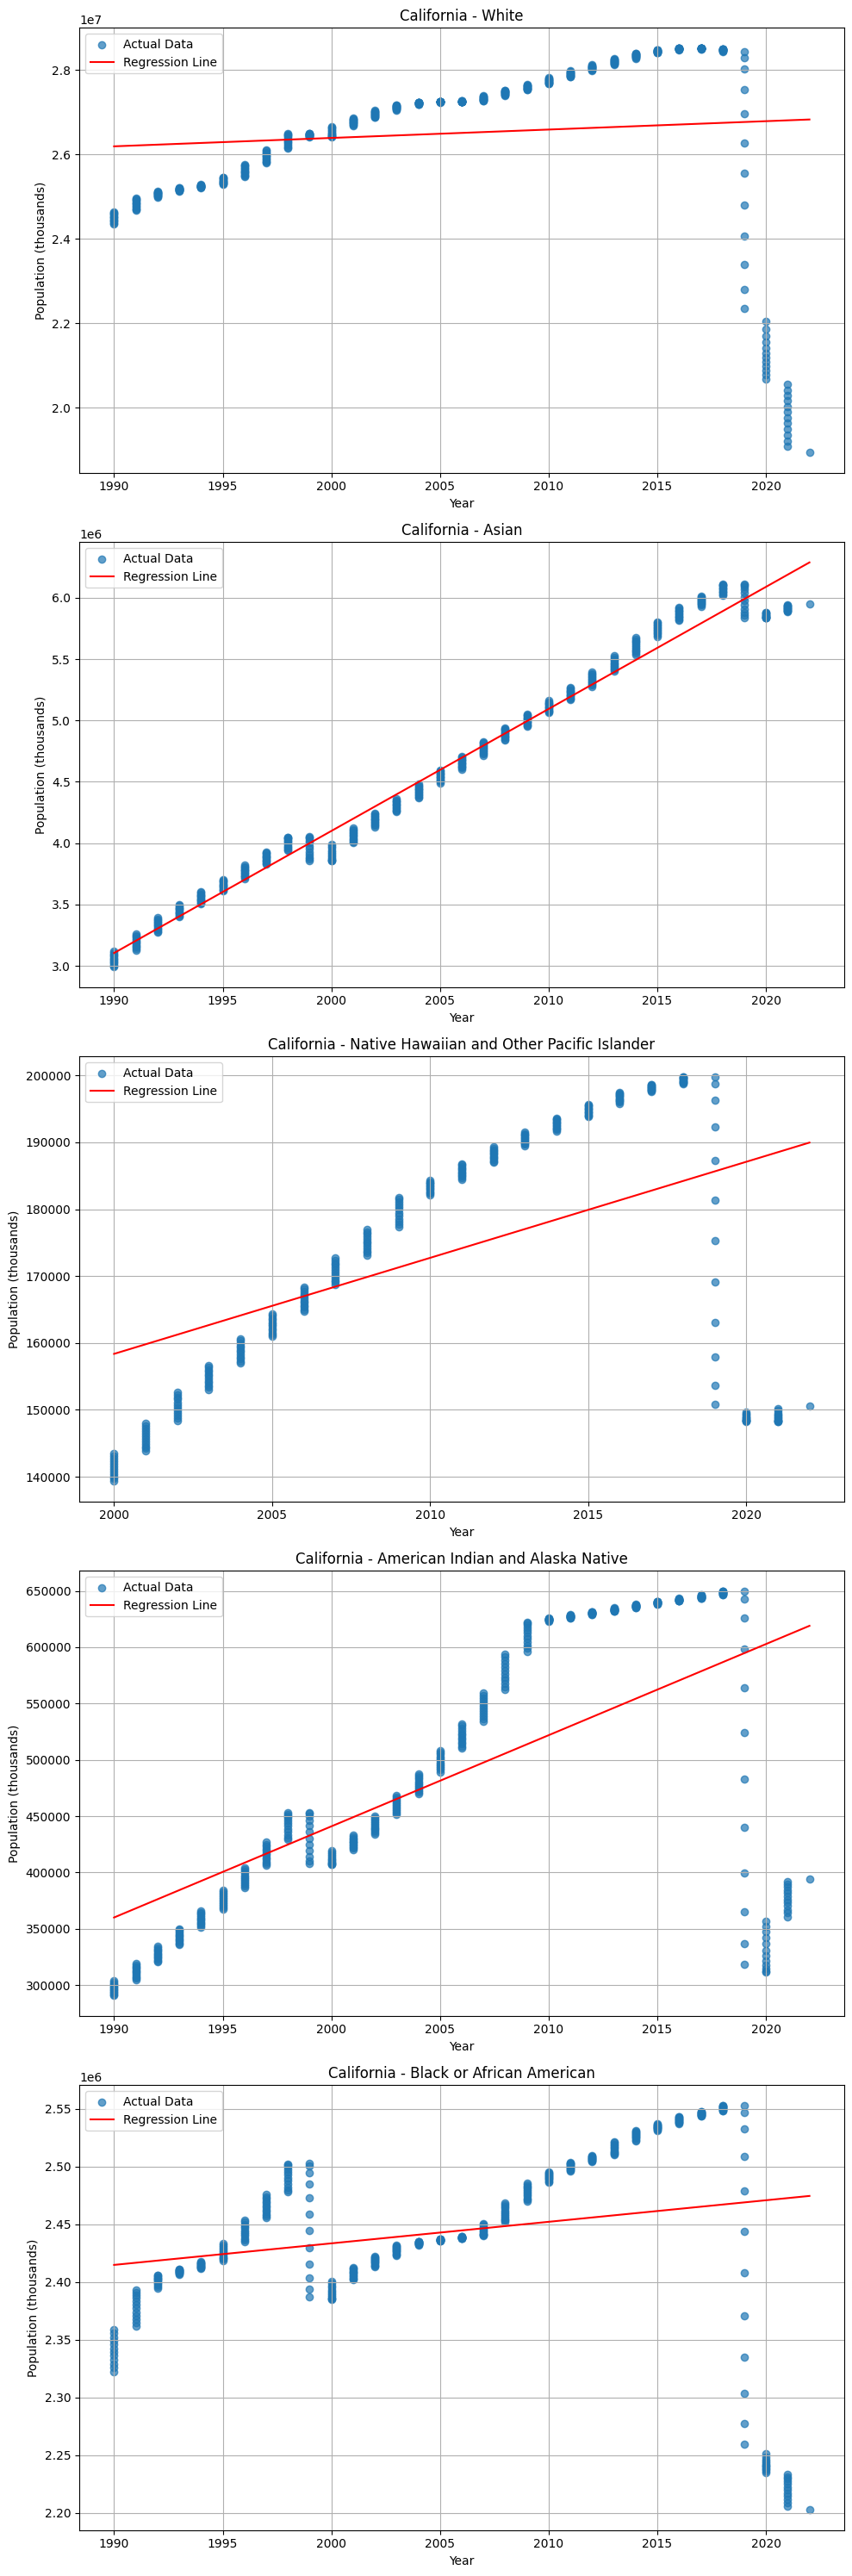

Plotting results for Alabama...


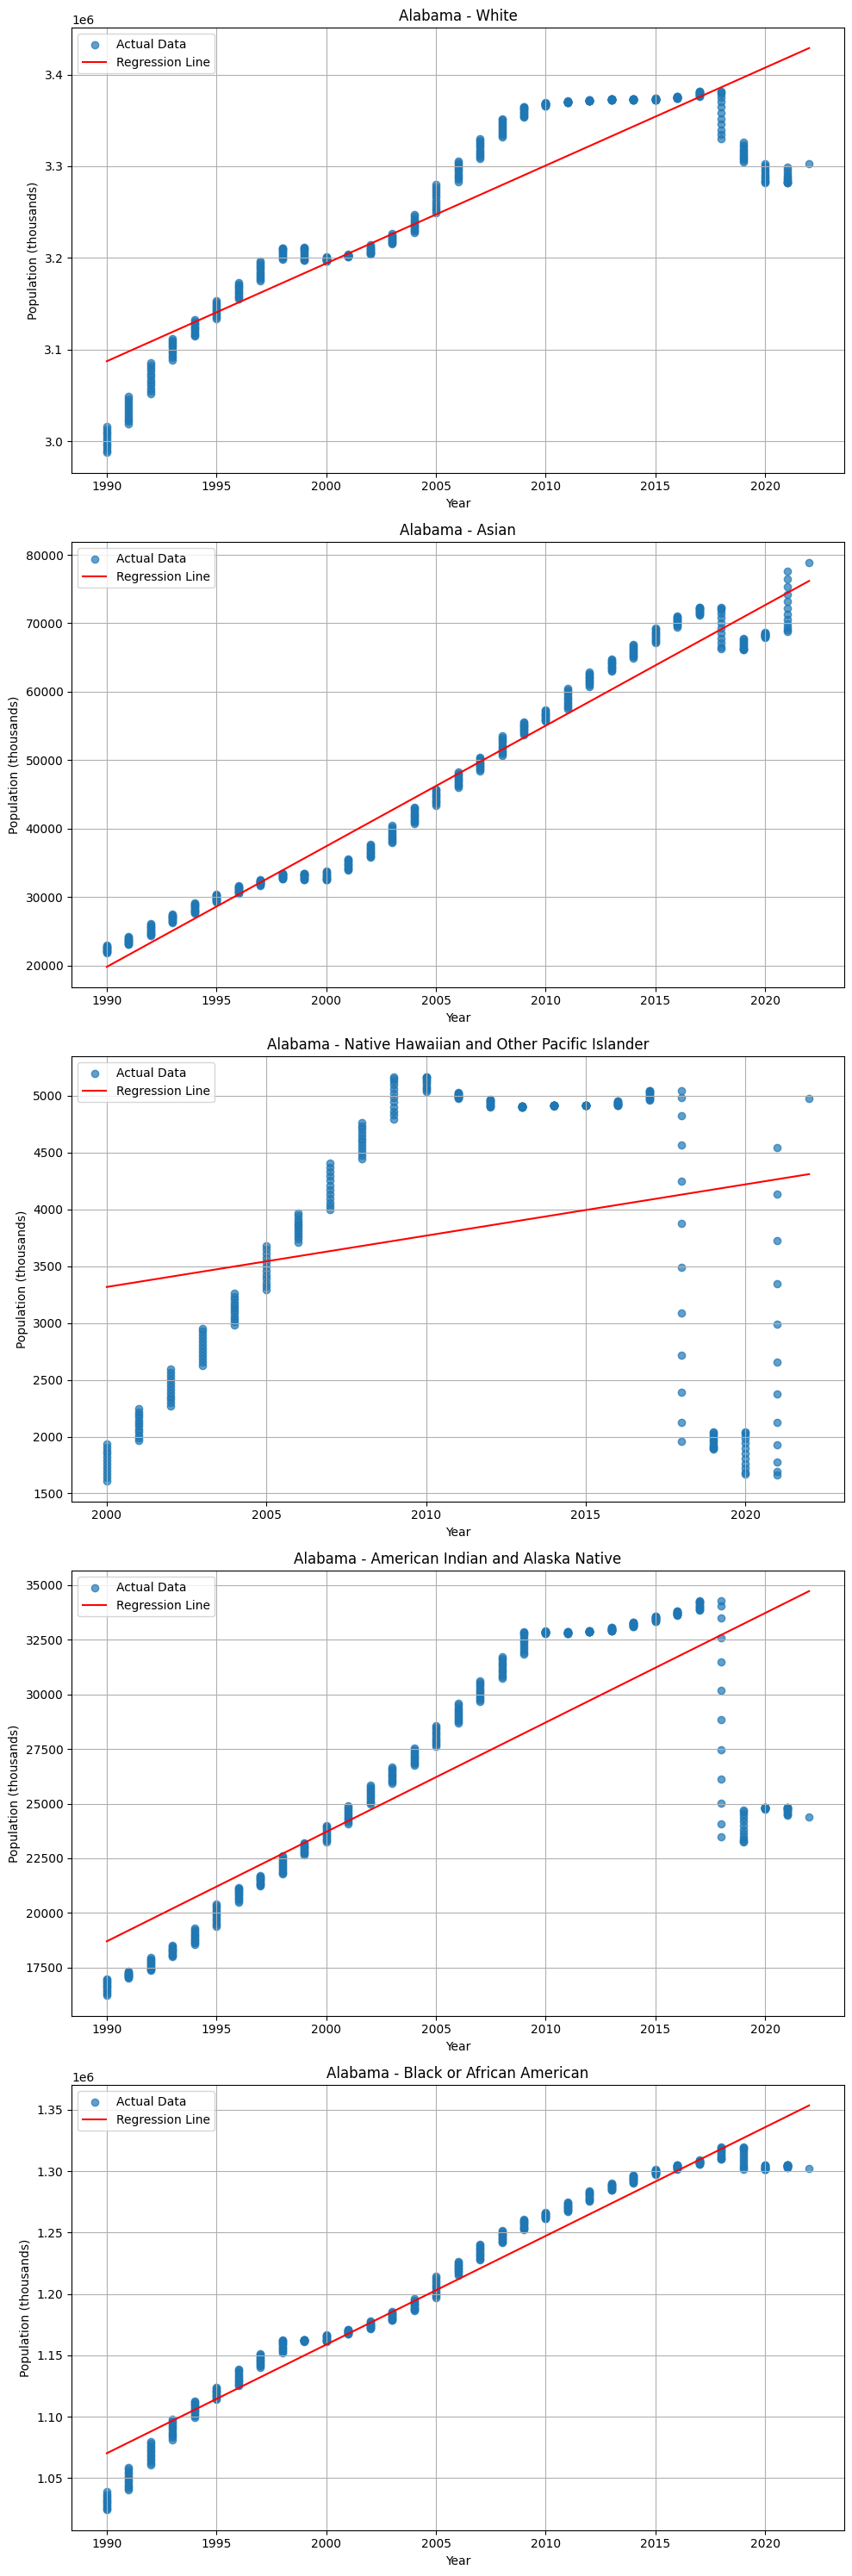

Plotting results for Texas...


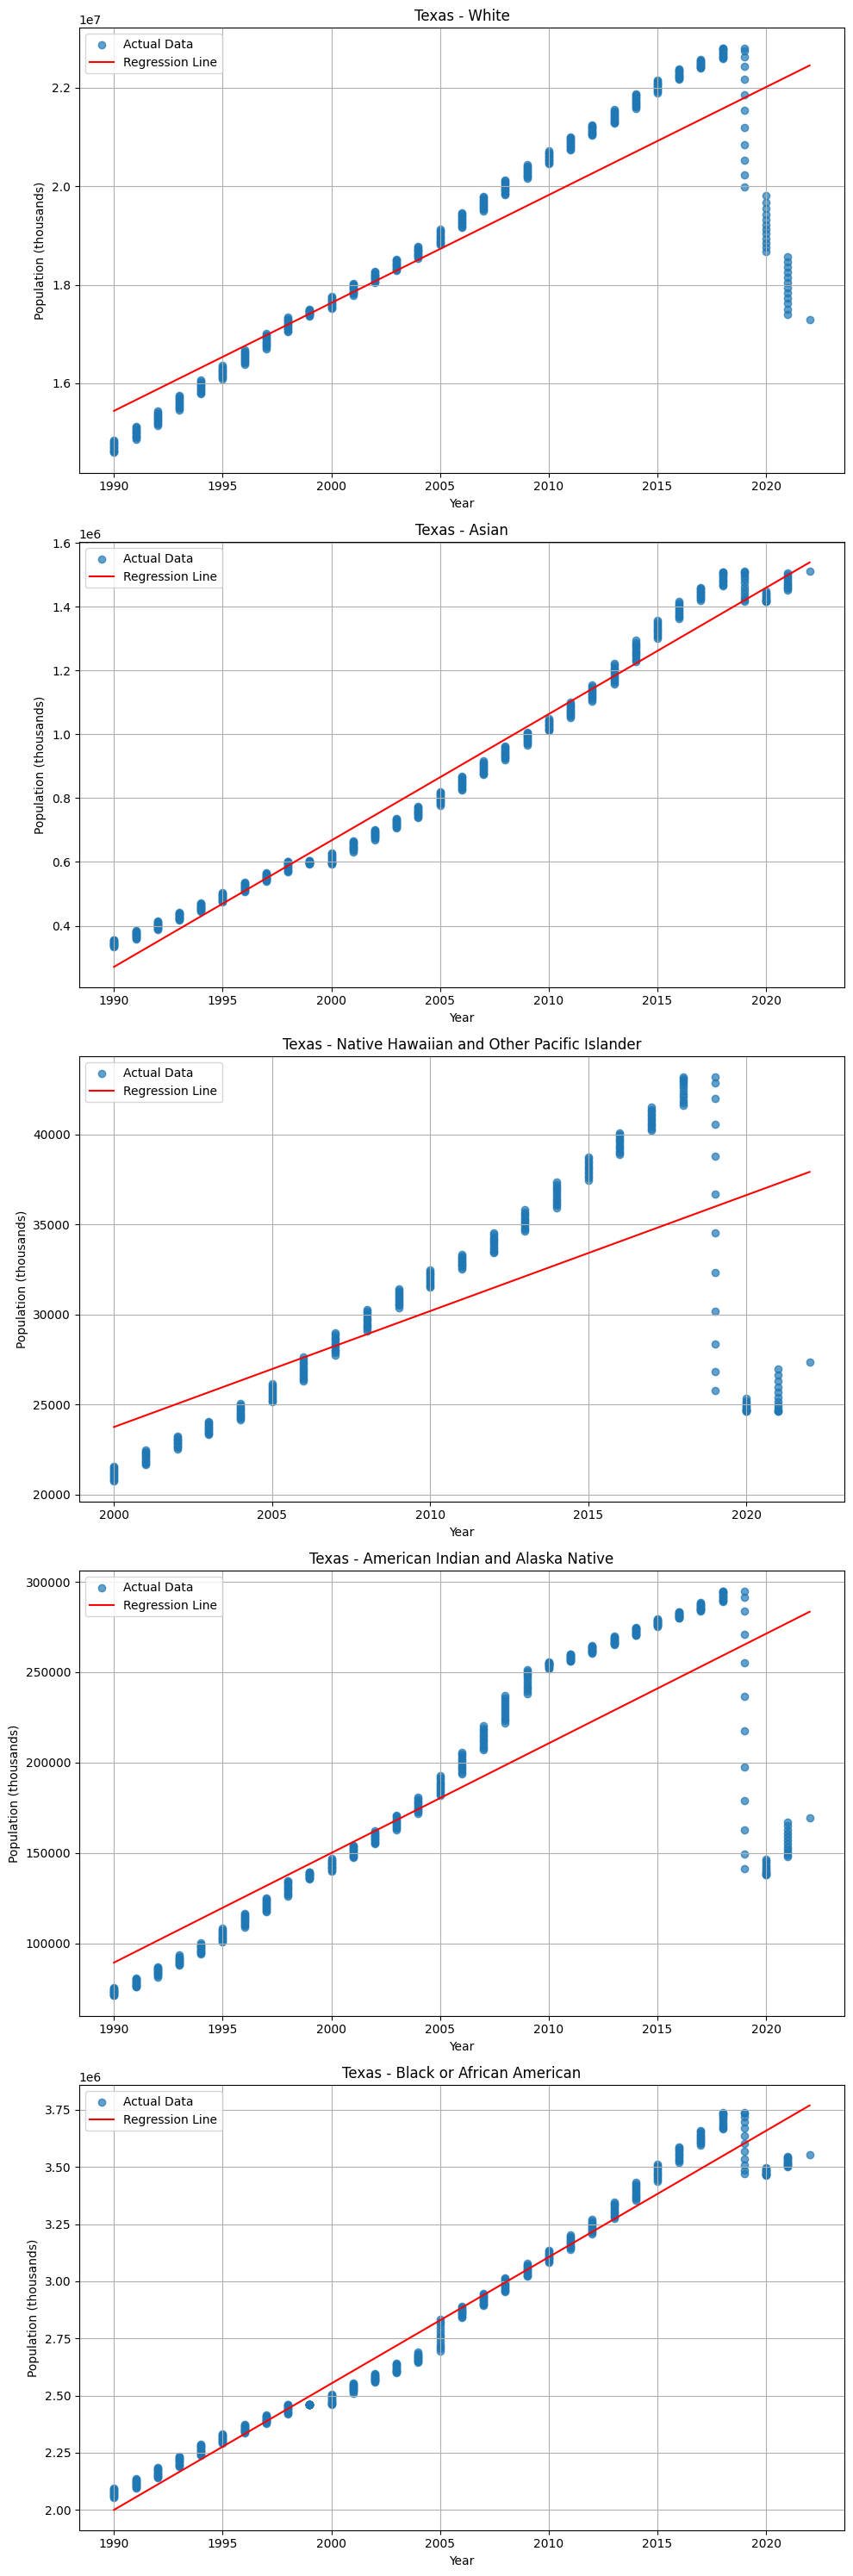

Plotting results for NewYork...


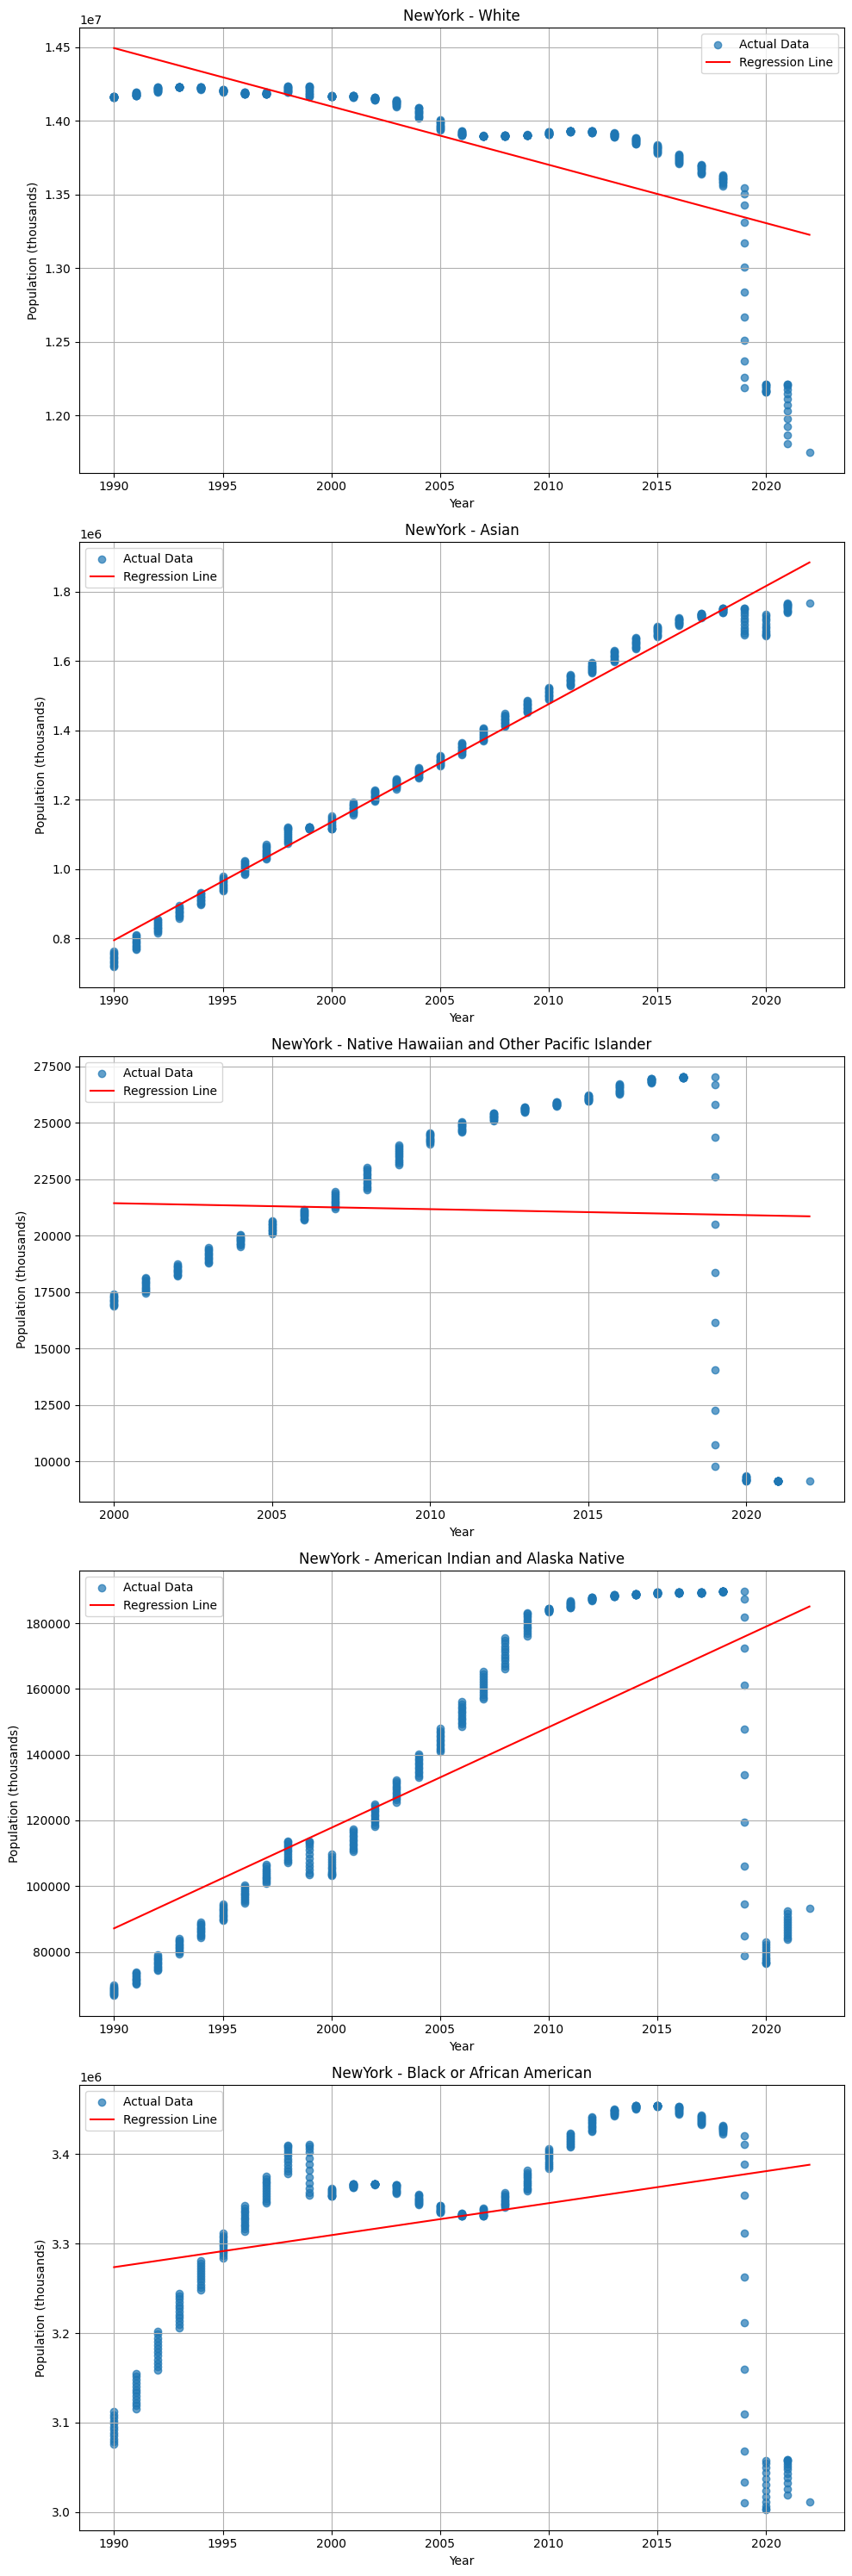

Plotting results for Hawaii...


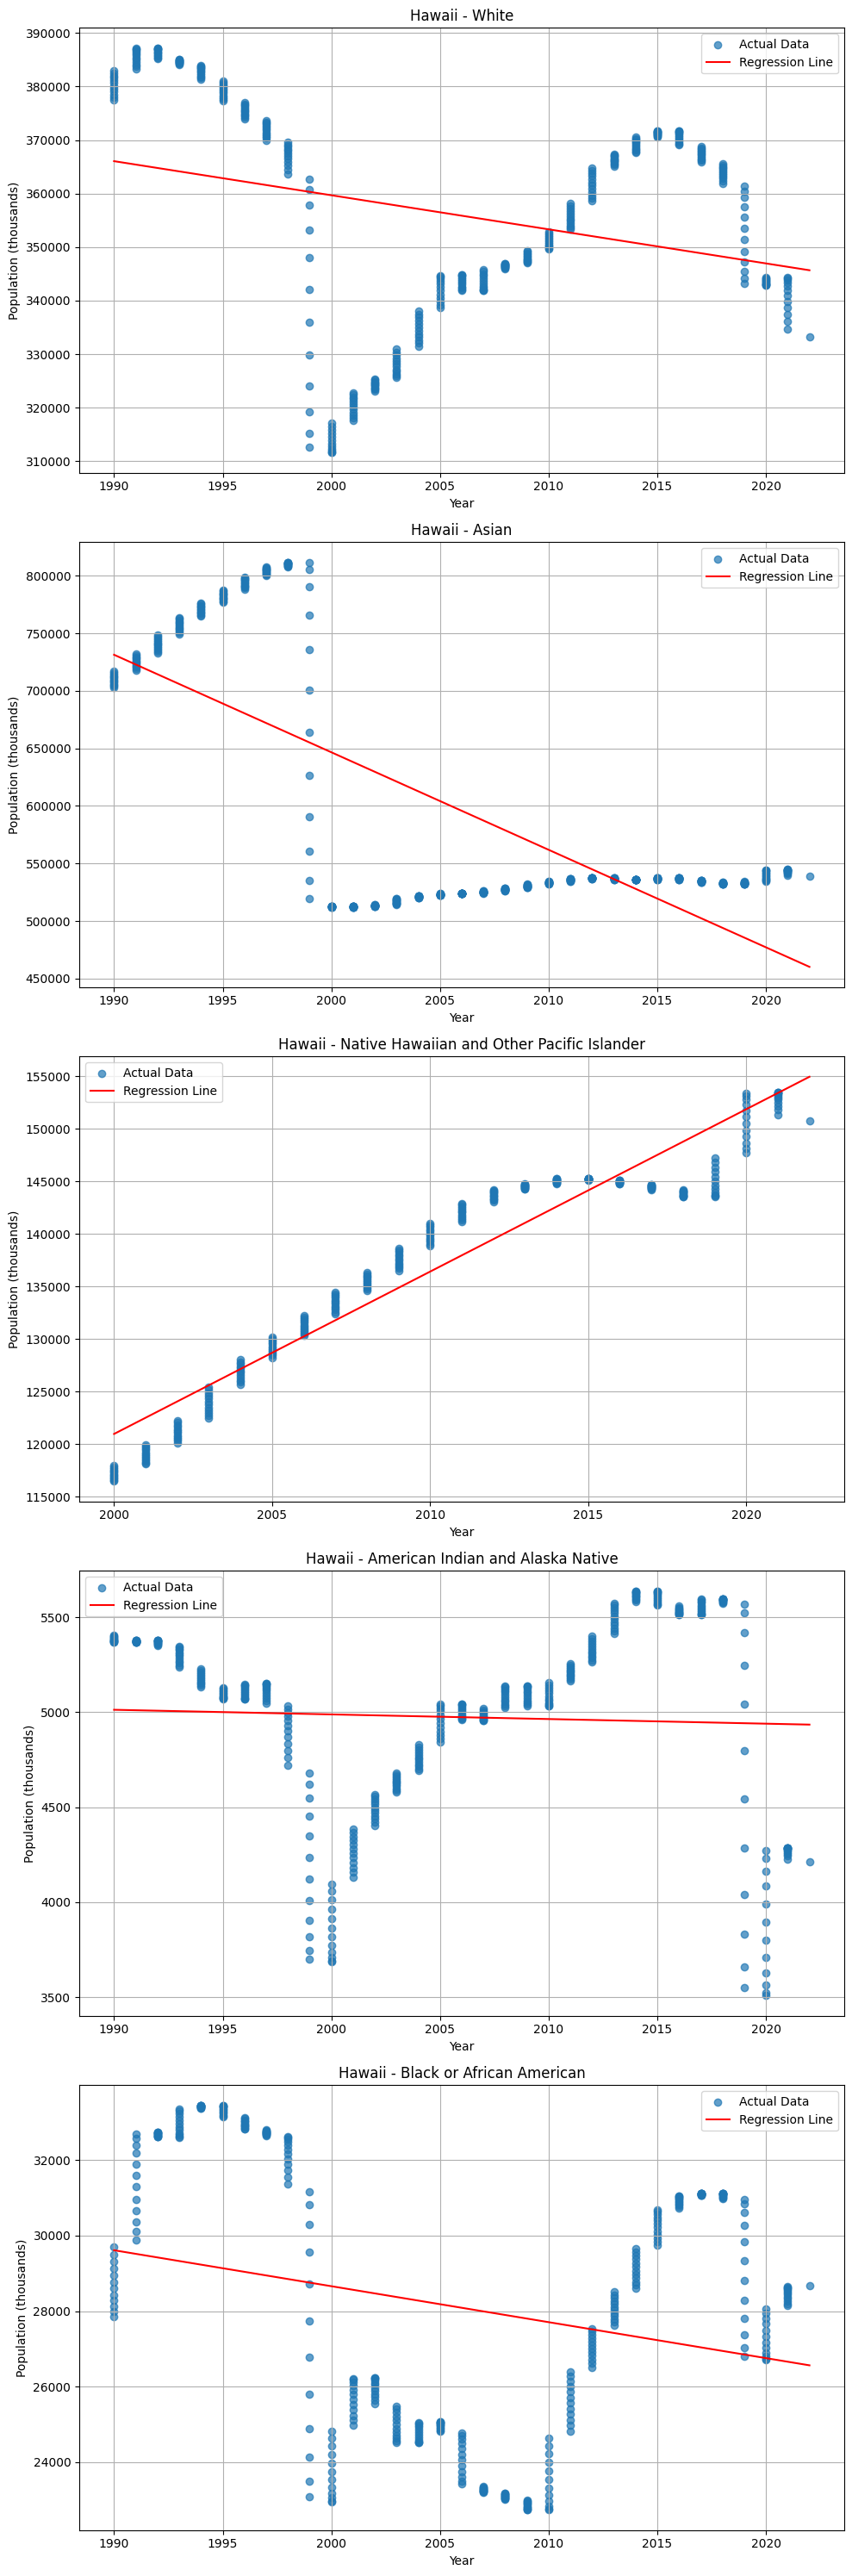

Plotting results for Wyoming...


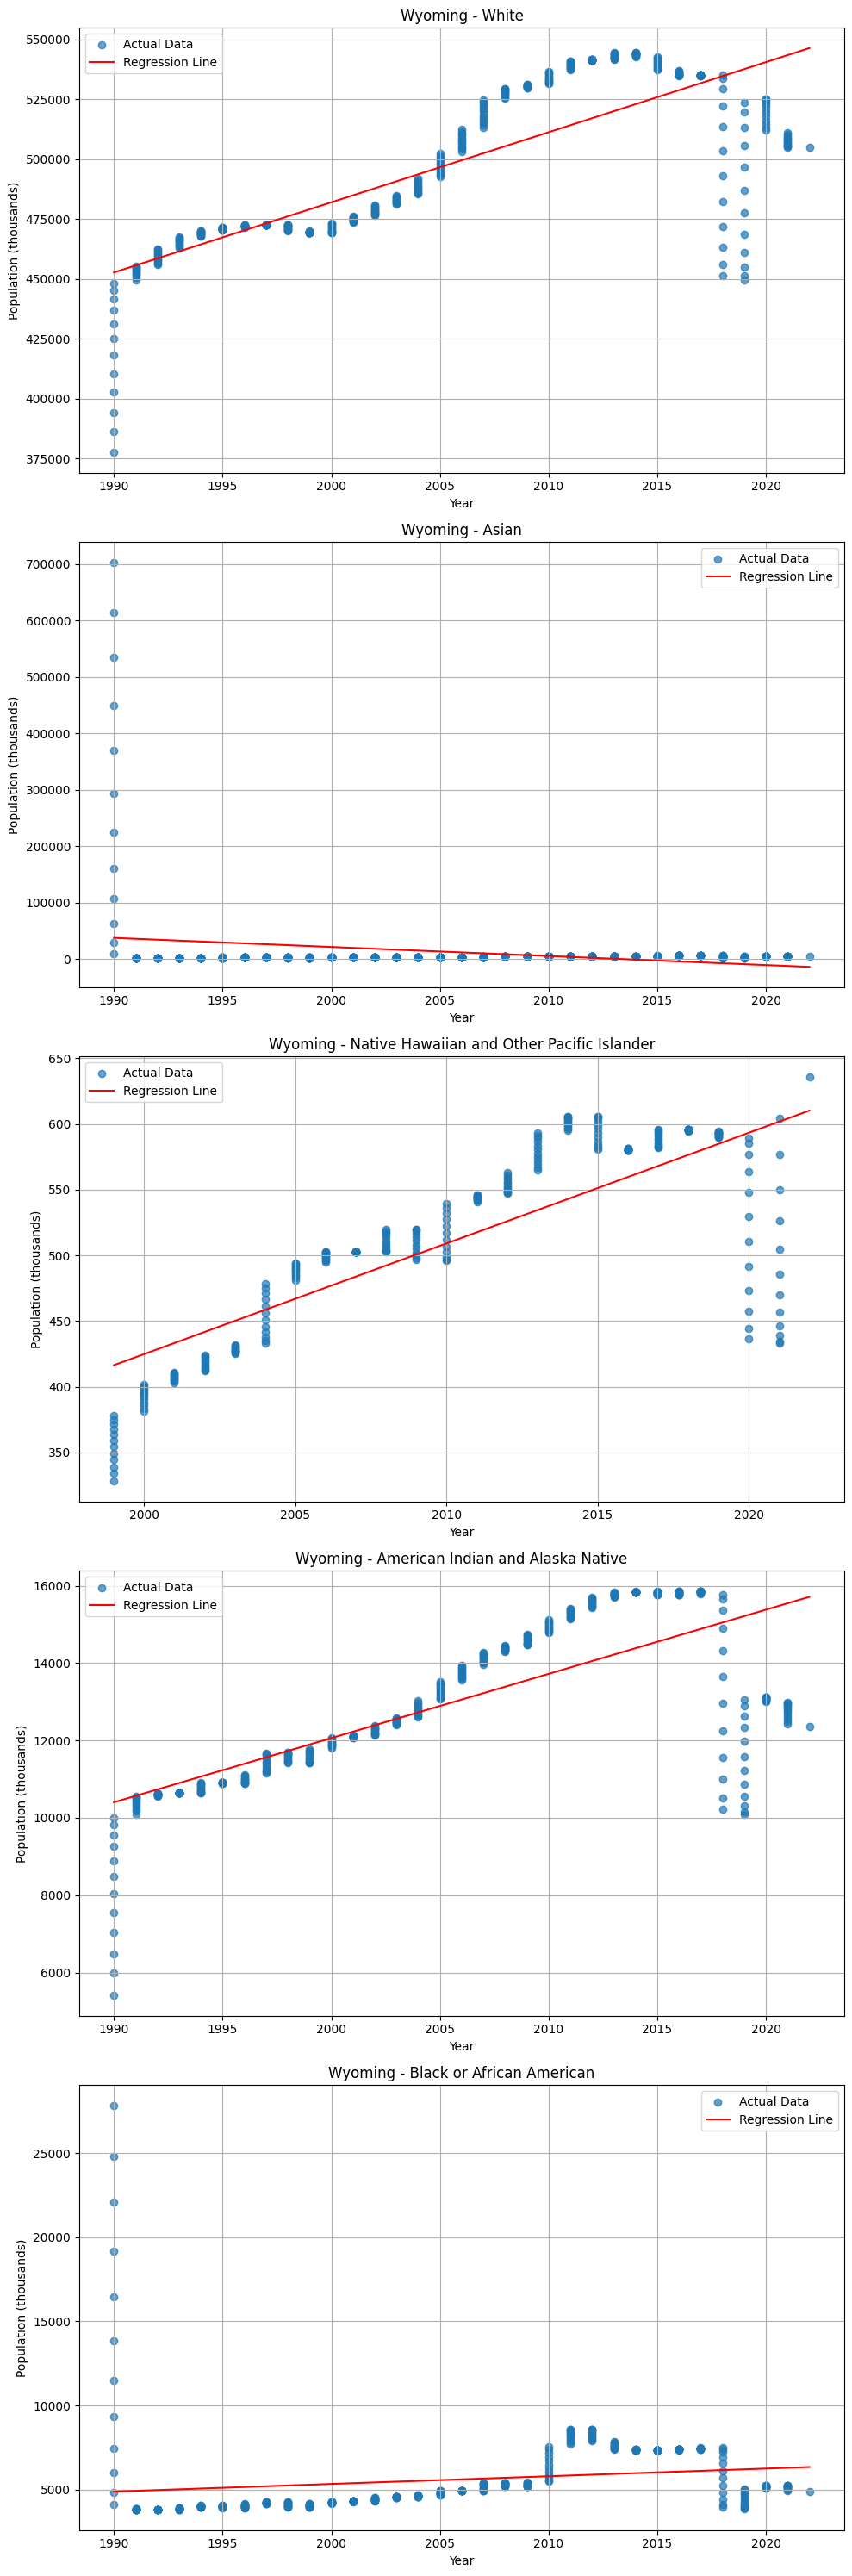

Results for California:
  Ethnic group: White
    MSE: 3688813156634.99
    R-squared: 0.02
  Ethnic group: Asian
    MSE: 13575727122.17
    R-squared: 0.98
  Ethnic group: Native Hawaiian and Other Pacific Islander
    MSE: 299914634.25
    R-squared: 0.28
  Ethnic group: American Indian and Alaska Native
    MSE: 6082743792.65
    R-squared: 0.57
  Ethnic group: Black or African American
    MSE: 7741660873.83
    R-squared: -0.06
Results for Alabama:
  Ethnic group: White
    MSE: 2481593278.19
    R-squared: 0.77
  Ethnic group: Asian
    MSE: 8220758.59
    R-squared: 0.97
  Ethnic group: Native Hawaiian and Other Pacific Islander
    MSE: 1314820.80
    R-squared: 0.05
  Ethnic group: American Indian and Alaska Native
    MSE: 17870850.03
    R-squared: 0.31
  Ethnic group: Black or African American
    MSE: 281985720.47
    R-squared: 0.96
Results for Texas:
  Ethnic group: White
    MSE: 1229976694872.88
    R-squared: 0.80
  Ethnic group: Asian
    MSE: 3644215801.81
    R-sq

In [7]:
if __name__ == "__main__":
    states = ["California", "Alabama","Texas", "NewYork", "Hawaii", "Wyoming"]
    dataset_path_template = "AdityaA44/MonthlyRacepopulation{state}"
    
    # Initialize regression analysis
    analysis = RegressionAnalysis()

    # Load data for each state
    for state in states:
        state_dataset = StateDataset(state)
        state_dataset.load_and_prepare_data(dataset_path_template.format(state=state))
        analysis.add_state_data(state, state_dataset)
        analysis.perform_regression()
        analysis.plot_results()

    # Perform regression
    

    # Get and display results
    results = analysis.get_results()
    for state, groups in results.items():
        print(f"Results for {state}:")
        for group, metrics in groups.items():
            print(f"  Ethnic group: {group}")
            print(f"    MSE: {metrics['mse']:.2f}")
            print(f"    R-squared: {metrics['r_squared']:.2f}")